In [1]:
import pandas as pd
import pickle as pickle
import numpy as np
from datetime import datetime
from datetime import date
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings; warnings.simplefilter('ignore')
import seaborn as sns

pd.set_option('display.max_columns', None)


### Conts 

In [2]:
# Background graph style
sns.set(style="darkgrid")
sns.set(style="whitegrid")


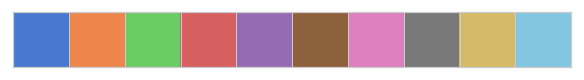

In [3]:
# ==============
# Chouse color
# ==============
sns.palplot(sns.color_palette("muted"))  # show color
sns.set_palette("muted") # for seaborn
colors = sns.color_palette("muted") # for pyplot

### Functions 

In [4]:
# ------------------------------- FUNCIONES ---------------------------------------- #

def woe(catvar,target, data):
    data_aggr = data.groupby([catvar,target]).size().reset_index()
    data_aggr.columns = [catvar,'target','numreg']
    
    # calculamos totales target
    non_event_total= np.sum(data_aggr[data_aggr.target==0]['numreg'])
    event_total = np.sum(data_aggr[data_aggr.target==1]['numreg']) 
    
    # pivoteamos data frame
    data_aggr = data_aggr.pivot(index=catvar, columns='target', values='numreg').reset_index()
    data_aggr.columns = [catvar,'non_event','event']
    
    # calculamos rate de event
    data_aggr['event_rate'] = data_aggr['event']/event_total
    data_aggr['non_event_rate'] = data_aggr['non_event']/non_event_total
    
    # calculamos woe
    data_aggr['woe'] = np.log(data_aggr['event_rate']/data_aggr['non_event_rate'])
    
    # calculamos IV
    data_aggr['rate_diff'] = data_aggr['event_rate'] - data_aggr['non_event_rate']
    data_aggr['information_value'] = data_aggr['rate_diff']*data_aggr['woe']
    #data_aggr['IV'] = data_aggr['IV'].sum()
    
    
    return data_aggr[[catvar,'woe','information_value','event_rate','non_event_rate']]

In [5]:
def info_value(woe_data):
    iv = woe_data['information_value'].sum()
    predictive_power = ""
    if iv < 0.02:
        predictive_power = "useless for prediction"
    elif iv >= 0.02 and iv < 0.1:
        predictive_power = "weak predictor"
    elif iv >= 0.1 and iv < 0.3:
        predictive_power = "medium predictor"
    elif iv >= 0.3 and iv < 0.5:
        predictive_power = "strong predictor"
    else:
        predictive_power = "suspicious predictor"
        
    return iv,predictive_power

In [6]:
def barprop(yvalue, xvalue, stitle, size, data):
    table=pd.crosstab(data[xvalue],data[yvalue])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.figure(figsize=size)
    
    if len(stitle)==0: # default title
        stitle = "Proportion bar graph"
    
    plt.title(stitle)
    plt.xlabel(xvalue)
    plt.ylabel(yvalue)
    plt.legend(train[yvalue].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pass

In [7]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

In [8]:
# =========================
#  Histogram
# =========================
def simpleHistGraph(numvar,  data, bins=10):
    g = data[numvar].hist(bins=bins)
    g.set_title(numvar +" distribucion ")
    pass

In [9]:
def countBarPlot(catvar, data, scale="linear", orient="h", rot=0, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    g = sns.countplot(x = catvar, data=data, orient=orient)
    loc, labels = plt.xticks()
    g.set_xticklabels(labels, rotation=rot)
    g.set_yscale(scale)
    
    g.set_title("Number of cases by " + catvar.upper())
    plt.show()
    pass

### Load Data

In [10]:
# Load Train Data
rawdata = pd.read_csv('../data/raw/train_aggr.csv',sep=';')

### Describe Data

In [11]:
rawdata.shape

(34540, 36)

In [12]:
rawdata.head()

,id_pos,fecha_venta_norm,canal,unidades,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
0,3142,2012-12-01,ALMACEN,12,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,5.020,5.390000,7.696667,7.916667,7.380000,6.606667,6.583333,6.290000,6.740000,6.710000,5.310000,4.683333,3.543333,2.820000,2.093333,2.296667,17.613333,1.333333,27.63,7.396667,0.260000,6.733333,0.72,0.210,3.793333,252050.3467
1,3142,2013-12-01,ALMACEN,7,12.0,50395.31667,68263.48667,17239.673330,6.796667,6.110000,5.020,5.390000,7.696667,7.916667,7.380000,6.606667,6.583333,6.290000,6.740000,6.710000,5.310000,4.683333,3.543333,2.820000,2.093333,2.296667,17.613333,1.333333,27.63,7.396667,0.260000,6.733333,0.72,0.210,3.793333,252050.3467
2,3143,2013-11-01,ALMACEN,2,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,6.090,5.933333,6.386667,6.670000,6.863333,6.526667,6.576667,6.333333,7.093333,6.843333,6.116667,5.036667,3.753333,3.066667,2.330000,2.163333,15.970000,0.936667,29.50,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067
3,3143,2013-12-01,ALMACEN,47,33.0,55256.52333,70989.74667,67764.126670,6.316667,5.903333,6.090,5.933333,6.386667,6.670000,6.863333,6.526667,6.576667,6.333333,7.093333,6.843333,6.116667,5.036667,3.753333,3.066667,2.330000,2.163333,15.970000,0.936667,29.50,7.560000,0.366667,8.410000,22.81,0.240,3.006667,391646.2067
4,3144,2012-11-01,ALMACEN,6,38.0,43437.32000,58236.36500,8799.223333,7.270000,7.240000,7.055,6.766667,7.895000,7.750000,7.288333,6.421667,6.578333,6.108333,5.871667,5.575000,4.793333,3.938333,3.165000,2.406667,1.815000,2.065000,15.360000,1.841667,28.13,6.546667,0.183333,1.466667,0.00,0.025,1.518333,137570.5233


In [13]:
rawdata.sample(n=5)

,id_pos,fecha_venta_norm,canal,unidades,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
7929,5325,2012-12-01,ALMACEN,21,6.0,50265.92500,60191.67500,9800.530000,6.495000,6.900000,6.915,6.450000,6.190000,6.220000,6.725000,6.170000,7.360000,6.220000,7.740000,7.295000,5.700000,4.715000,3.440000,2.390000,1.755,1.320000,8.295000,0.335000,39.710000,3.860000,0.340000,1.935000,0.060000,0.030000,2.300000,146567.3150
11403,6225,2012-12-01,ALMACEN,74,57.0,62455.41444,79689.44778,21314.301110,5.804444,5.993333,6.060,6.037778,6.635556,6.807778,7.063333,6.390000,6.973333,6.641111,7.355556,6.721111,5.824444,4.724444,3.505556,2.737778,2.310,2.413333,21.118889,1.074444,25.086667,8.136667,1.581111,3.737778,5.112222,0.187778,3.576667,314791.6344
14583,7077,2013-12-01,ALMACEN,32,6.0,118990.09000,140794.47000,13145.920000,6.760000,7.120000,7.220,7.070000,6.210000,6.440000,7.500000,7.280000,8.140000,8.310000,9.050000,6.650000,4.790000,3.070000,1.980000,1.050000,0.700,0.650000,30.250000,1.900000,20.590000,14.370000,0.220000,1.450000,0.810000,0.010000,0.850000,386515.9500
29721,14765,2014-11-01,ALMACEN,1,29.0,42142.97250,55711.58000,6833.290000,6.600000,6.462500,6.540,7.710000,8.765000,7.257500,7.237500,5.912500,5.587500,5.345000,6.462500,6.245000,5.355000,4.420000,3.295000,2.447500,2.015,2.347500,14.875000,0.572500,27.252500,5.080000,1.175000,0.892500,0.000000,0.127500,4.997500,148787.0325
29939,14886,2013-11-01,ALMACEN,1,62.0,57865.80385,76051.52308,6522.581538,6.376923,5.812308,5.390,5.797692,10.099231,9.540769,7.860000,6.076154,5.932308,5.643077,6.186154,6.002308,5.262308,4.325385,3.102308,2.378462,1.960,2.252308,22.184615,1.360000,23.744615,9.785385,0.457692,1.400000,0.361538,0.049231,2.349231,191728.6646


In [14]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34540 entries, 0 to 34539
Data columns (total 36 columns):
id_pos                  34540 non-null int64
fecha_venta_norm        34540 non-null object
canal                   34540 non-null object
unidades                34540 non-null int64
competidores            34465 non-null float64
ingreso_mediana         34537 non-null float64
ingreso_promedio        34537 non-null float64
densidad_poblacional    34536 non-null float64
pct_0a5                 34540 non-null float64
pct_5a9                 34536 non-null float64
pct_10a14               34535 non-null float64
pct_15a19               34540 non-null float64
pct_20a24               34536 non-null float64
pct_25a29               34536 non-null float64
pct_30a34               34536 non-null float64
pct_35a39               34536 non-null float64
pct_40a44               34536 non-null float64
pct_45a49               34536 non-null float64
pct_50a54               34536 non-null float64
pct_

In [15]:
rawdata.describe(include=['O']) # category data

,fecha_venta_norm,canal
count,34540,34540
unique,13,4
top,2013-12-01,ALMACEN
freq,11241,34223


In [16]:
rawdata.describe() # numerical data

,id_pos,unidades,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
count,34540.000000,34540.000000,34465.000000,34537.000000,34537.000000,34536.000000,34540.000000,34536.000000,34535.000000,34540.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,34536.000000,3.454000e+04
mean,9347.387956,17.699421,26.679298,55121.324915,72442.380820,11563.058361,6.020602,6.103735,6.048533,6.430865,7.731478,7.172010,6.840983,5.937262,6.282684,6.324274,6.930872,6.697229,5.808046,4.878134,3.640310,2.690759,2.098572,2.363034,18.014922,1.312406,28.594878,7.694712,0.622630,2.243800,1.428240,0.138744,3.616501,2.172540e+05
std,5361.372953,21.810790,47.297163,14843.099433,18896.541971,16164.284582,1.225916,1.183378,1.192273,1.851869,3.769658,2.018125,1.460609,0.936657,0.862055,0.901919,1.007789,1.077536,1.190205,1.304342,1.186219,0.936544,0.810827,1.196166,6.022795,1.026522,6.746538,3.449908,0.863861,2.763511,5.190659,0.332854,3.921918,1.196875e+05
min,3142.000000,1.000000,0.000000,15519.520000,22629.590000,0.050000,0.000000,0.000000,0.000000,0.120000,0.270000,0.320000,0.350000,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.950000,0.000000,3.590000,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,5510.750000,3.000000,4.000000,45679.405000,60066.641110,4513.167500,5.410000,5.520000,5.470000,5.647024,6.020000,6.042500,6.076500,5.478373,5.877500,5.900000,6.477000,6.181667,5.233333,4.210476,3.049167,2.203937,1.650000,1.690000,14.154750,0.681429,24.710000,5.403333,0.160000,0.625000,0.000000,0.000000,1.622768,1.444145e+05
50%,7762.000000,10.000000,14.000000,53941.904000,70610.888330,8475.040000,5.990909,6.096435,6.060000,6.204500,7.002500,7.005000,6.784000,5.940000,6.311833,6.330000,6.933600,6.680000,5.720000,4.743693,3.510000,2.600000,2.026000,2.220000,18.110000,1.140000,28.060000,7.470000,0.410000,1.566667,0.072500,0.045000,2.570000,1.959691e+05
75%,12647.000000,23.000000,32.000000,62119.430000,81274.360000,12859.321670,6.596786,6.700000,6.689167,6.845000,8.290000,8.000000,7.495250,6.393333,6.730000,6.755000,7.433333,7.220000,6.290000,5.358571,4.040000,3.030000,2.406875,2.780000,21.359231,1.670000,32.223333,9.393935,0.768000,2.840000,0.523500,0.140000,4.170000,2.576959e+05
max,63432.000000,252.000000,2607.000000,165644.920000,201504.010000,278007.800000,19.320000,20.380000,15.280000,41.550000,73.540000,26.740000,18.480000,16.660000,14.980000,13.870000,14.243333,13.840000,17.360000,20.800000,19.670000,16.220000,17.300000,25.800000,46.700000,13.900000,57.420000,30.320000,17.890000,35.970000,72.970000,6.490000,80.960000,1.710129e+06


In [17]:
print(rawdata.nunique())

id_pos                  11853
fecha_venta_norm           13
canal                       4
unidades                  177
competidores              281
ingreso_mediana         11668
ingreso_promedio        11671
densidad_poblacional    11656
pct_0a5                  4600
pct_5a9                  4602
pct_10a14                4638
pct_15a19                4823
pct_20a24                5768
pct_25a29                5444
pct_30a34                4933
pct_35a39                4164
pct_40a44                4025
pct_45a49                4015
pct_50a54                4214
pct_55a59                4317
pct_60a64                4445
pct_65a69                4538
pct_70a74                4341
pct_75a79                4016
pct_80a84                3778
pct_85ainf               4337
pct_bachelors            7829
pct_doctorados           4058
pct_secundario           8016
pct_master               6521
pct_bicicleta            3357
pct_omnibus              5237
pct_subtes               3597
pct_taxi  

In [18]:
rawdata['fecha_venta_norm'] = pd.to_datetime(rawdata['fecha_venta_norm'])

In [19]:
rawdata['fecha_venta_norm'] = rawdata['fecha_venta_norm'].dt.date

### Explore Numerical Data

#### unidades (target)
- Se observan valores negativos. Debe ser un error de carga (imputar o borrar). Puede que tambien se deba a debitos de unidades (para compensar unidades vendidas cargadas de mas)
- La mediana se encuentra entre 1 y 2 unidades.
- Hay muchos outliers (se deberian tratar o no). NO son valores inusuales.

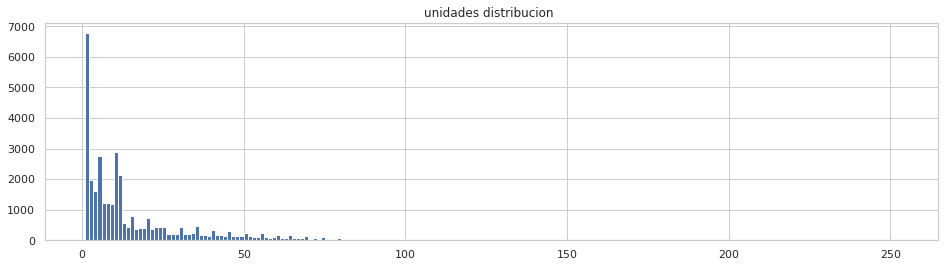

In [26]:
plt.figure(figsize=(16, 4))
simpleHistGraph('unidades',rawdata, bins=200)

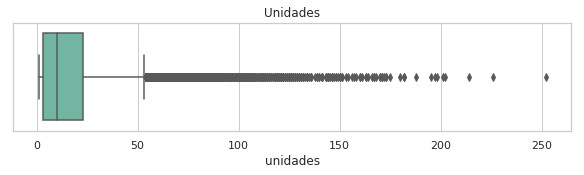

In [27]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="unidades", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de las unidades se conserva relativamente en todos los periodos.
- Se observa que la mayoria de los outliers se encuentran en los meses fin de año (11 y 12) por lo cual podemos afirmar que estos valores no son necesariamente outliers sino una mayor cantidad de ventas para esos periodos.
- Quizas se deberia hacer un modelo teniendo en cuenta esos periodos yo que los otros presenta valores estacionales diferentes al periodo que hay que scorear.

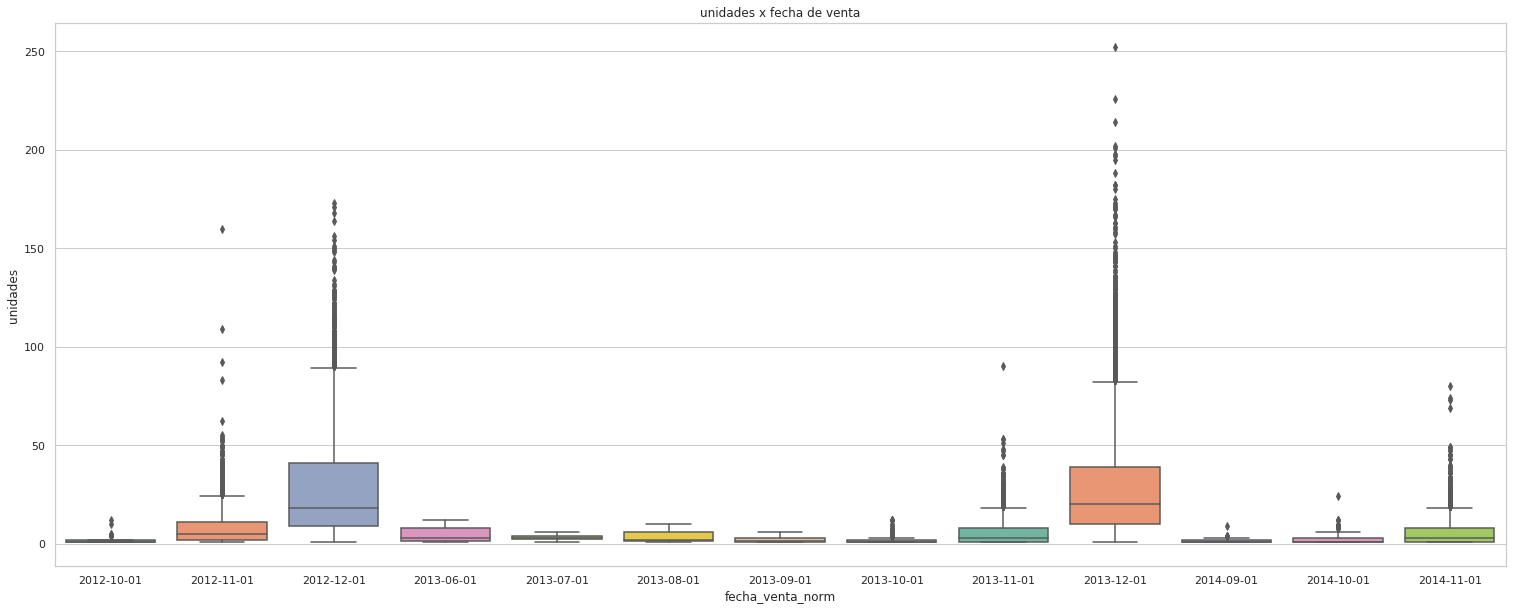

In [39]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_venta_norm", y="unidades", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("unidades x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- El numero de unidades vendidas se mantiene en la media cuando se lo analiza por el tipo de canal.
- El mayor numero de unidades aparece para el canal 'ALMACEN'
- Hay 79 pos con dos canales asignados. Ver si es un erorr o si se debe a un cambio de categoria de canal en el tiempo

In [29]:
canal_aggr = rawdata.groupby('id_pos').canal.nunique().reset_index()
canal_aggr.columns = ['id_pos','num_canales']

In [30]:
len(canal_aggr[canal_aggr.num_canales > 1])

79

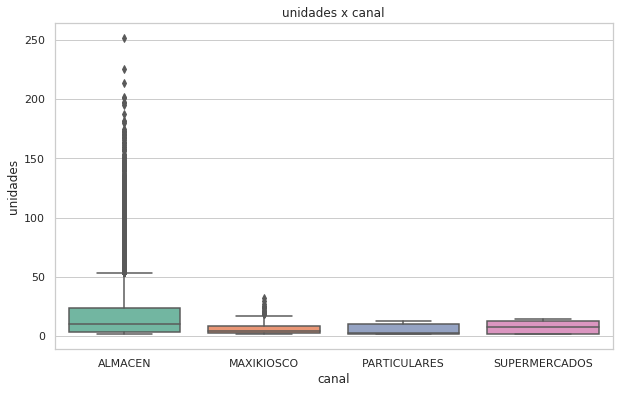

In [31]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="canal", y="unidades", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('canal')) # DataFrame, array, or list of arrays, optional
ax.set_title("unidades x canal")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### competidores
- Los valores son elevados. Se observan muchos outliers que parecieran poseer valores que no corresponden a la metrica

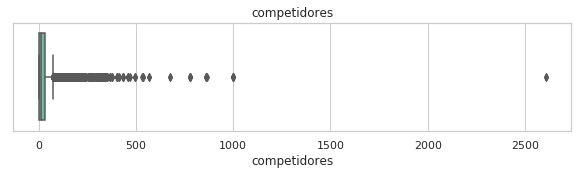

In [32]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="competidores", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("competidores")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de las unidades se conserva en todos los periodos a exepcion de los periodos cercanos a fin de año donde se observan la mayoria de los outliers. Esto puede deberse a que en esos periodos, al ser los de mayor consumo, aparecen mas puestos temporales.

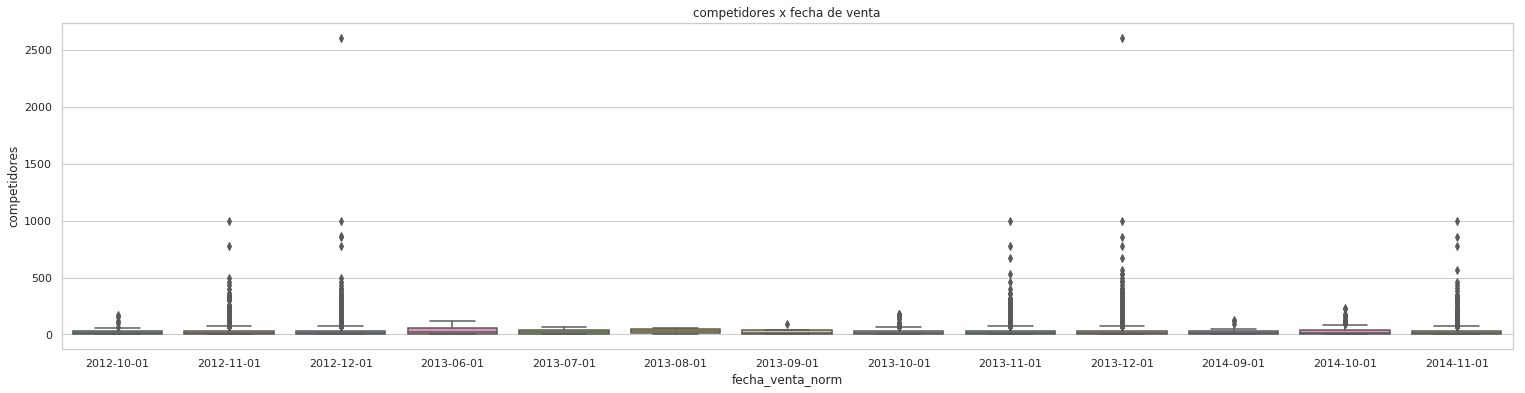

In [40]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="competidores", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("competidores x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### ingreso_mediana
- Los valores se encuentran entre 40000 y 60000
- Se presentan outliers con valores mayor a 100000. Son valores posibles o reales
- Pareciera estar expresado en pesos

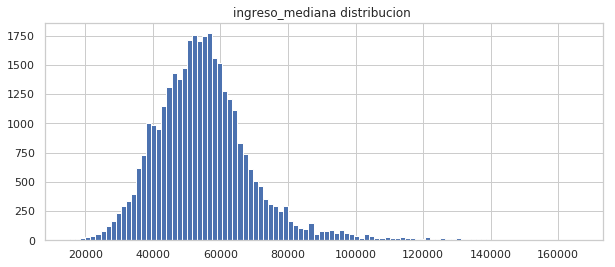

In [34]:
plt.figure(figsize=(10, 4))
simpleHistGraph('ingreso_mediana',rawdata, bins=100)

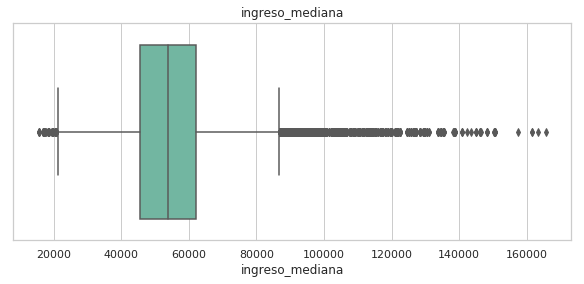

In [35]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x="ingreso_mediana", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_mediana")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion del ingreso medio se mantiene en los diferentes periodos. Lo cual resulta extraño si se considera el factor inflacionario.

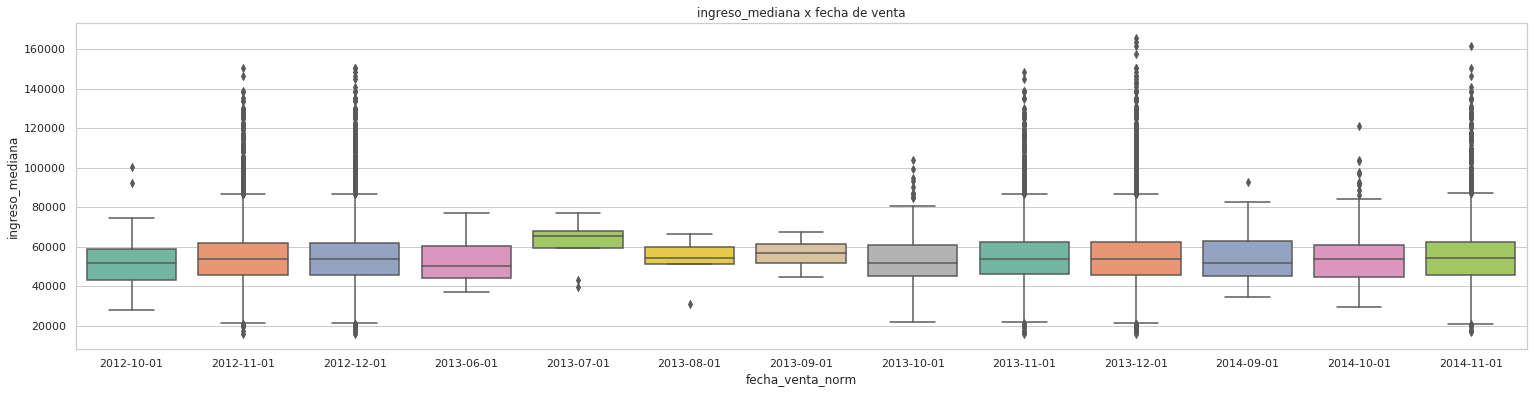

In [41]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="ingreso_mediana", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_mediana x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### ingreso_promedio
- Los valores se encuentran entre 60000 y 75000
- Se presentan outliers con valores mayor a 100000. Son valores posibles o reales
- Pareciera estar expresado en pesos
- presentan distribucion similar a ingreso_mediana

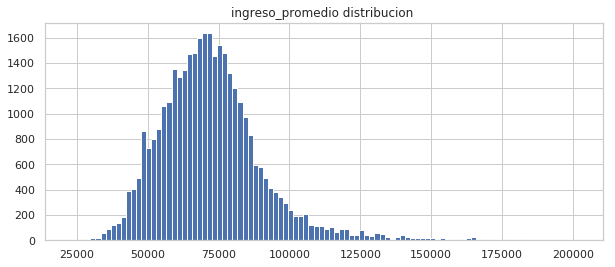

In [42]:
plt.figure(figsize=(10, 4))
simpleHistGraph('ingreso_promedio',rawdata, bins=100)

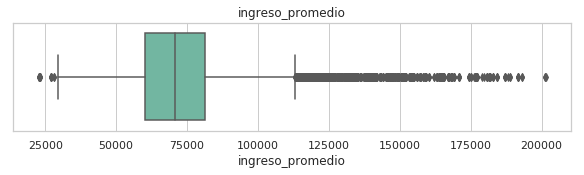

In [43]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="ingreso_promedio", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_promedio")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion del ingreso medio se mantiene relativamente en los diferentes periodos, aun que se observa variaciones, y mas si se lo compara con el ingreso_mediana, la cual no varia tanto debido a su comportamiento de no ser tan influido por los outliers.
- Como esta variable es mas suseptible a ouliers y esta correlacionada con ingreso_mediana, no se deberia considerar.

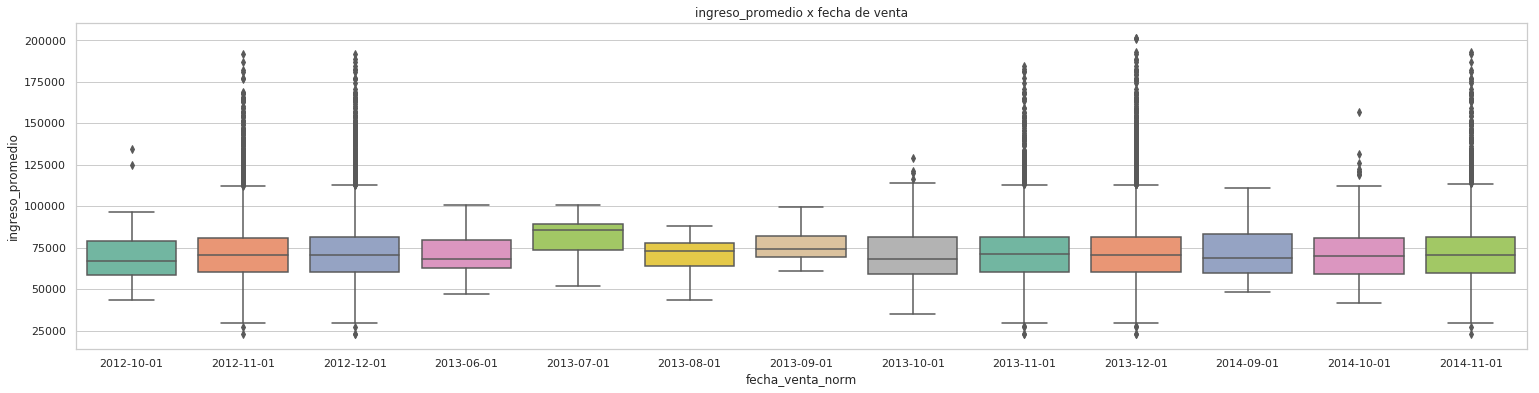

In [44]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="ingreso_promedio", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_promedio x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### densidad_poblacional
- Los valores se encuentran entre 40000 y 60000


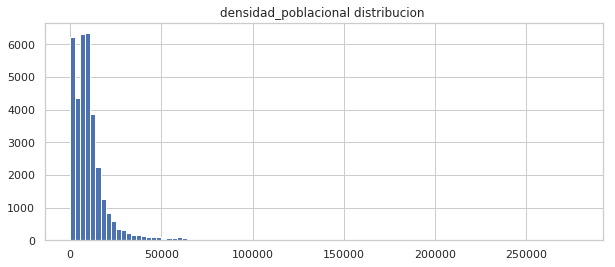

In [45]:
plt.figure(figsize=(10, 4))
simpleHistGraph('densidad_poblacional',rawdata, bins=100)

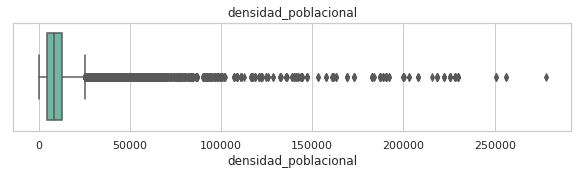

In [46]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="densidad_poblacional", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("densidad_poblacional")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion poblacional se mantiene en los diferentes periodos

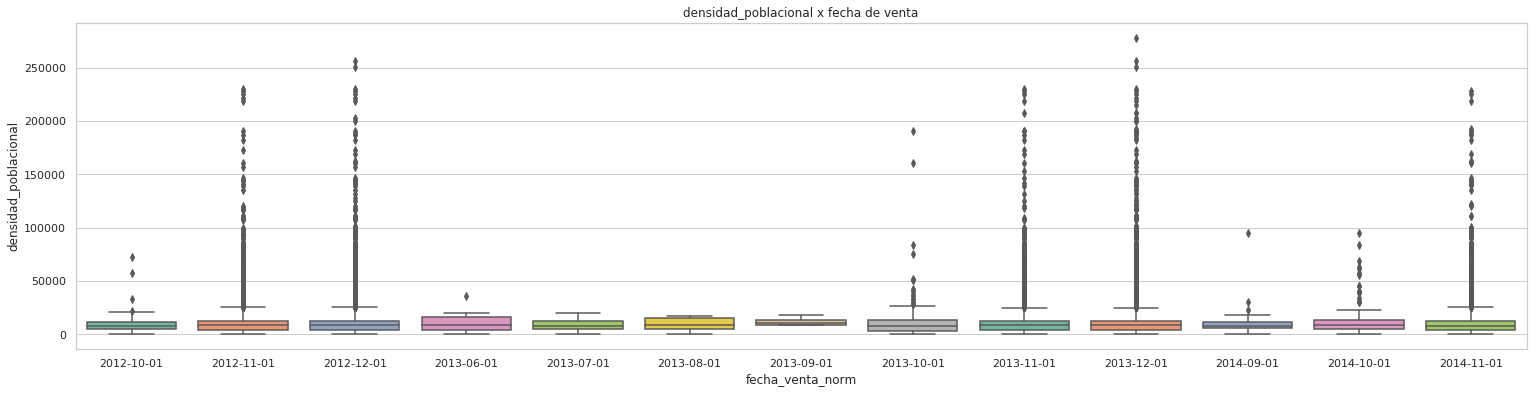

In [47]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="densidad_poblacional", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("densidad_poblacional x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_bachelors


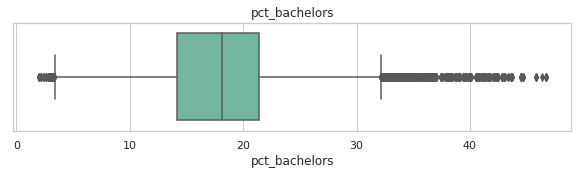

In [48]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_bachelors", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bachelors")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de pct_bachelors varia entre periodos
- La distribucion se conserva para los periodos 11 y 12

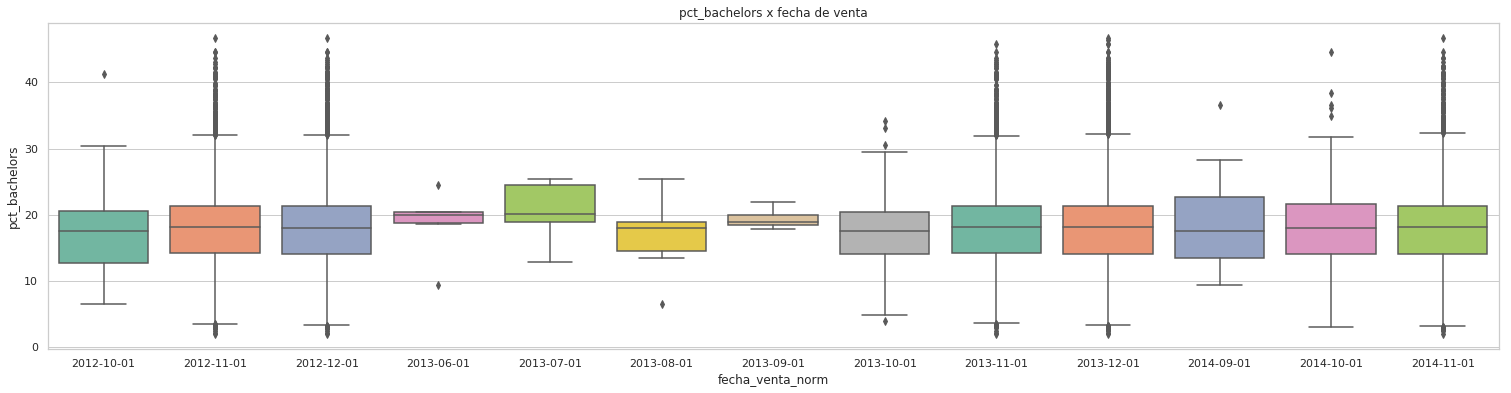

In [49]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_bachelors", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bachelors x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_doctorados
- Los valores se encuentran distribuidos entre valores bajos.

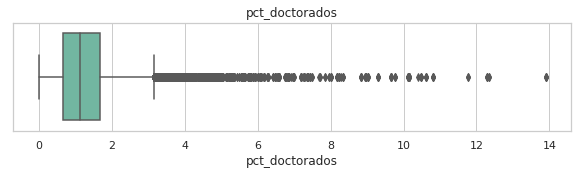

In [50]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_doctorados", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_doctorados")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La distribucion de pct_doctorados se mantiene en la mayoria de los periodos a execpcion de los periodos 6, 7, 8, 9 de 2013
- La distribucion se conserva para los periodos 11 y 12

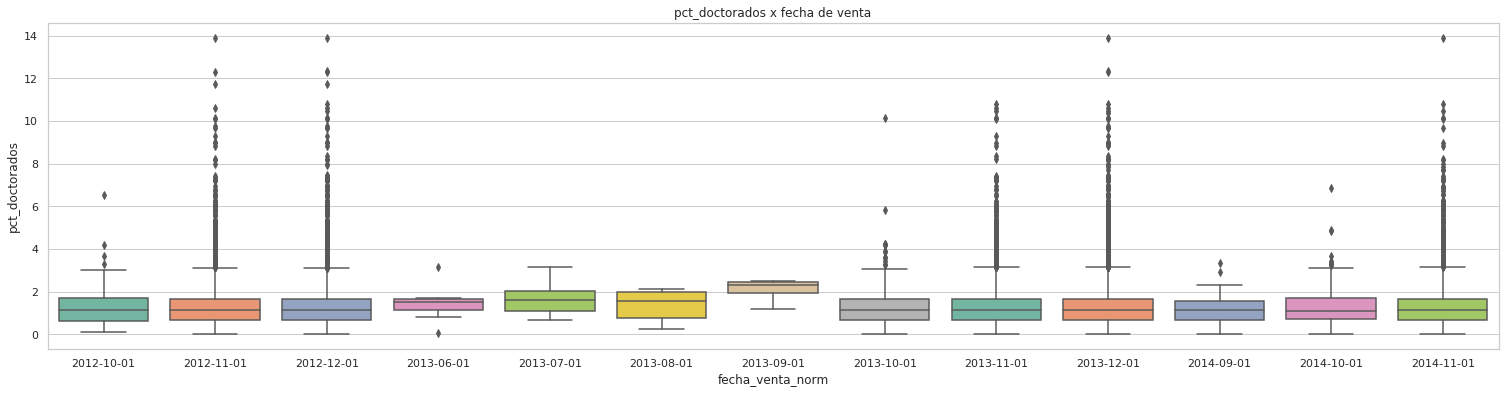

In [51]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_doctorados", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_doctorados x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_secundario


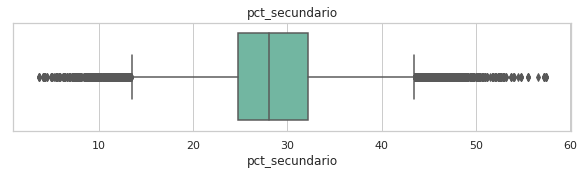

In [52]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_secundario", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_secundario")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

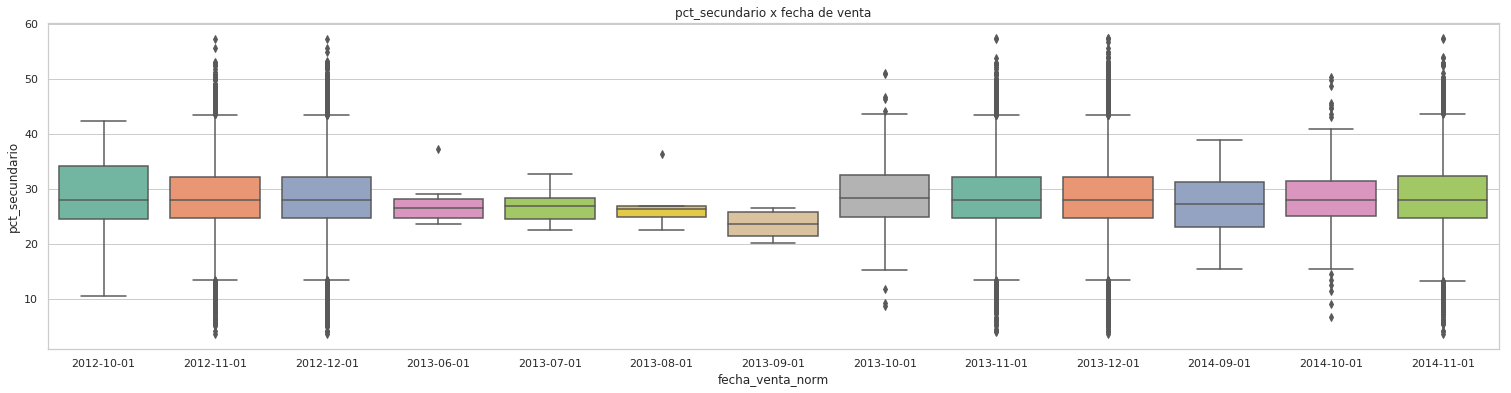

In [53]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_secundario", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_secundario x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_master


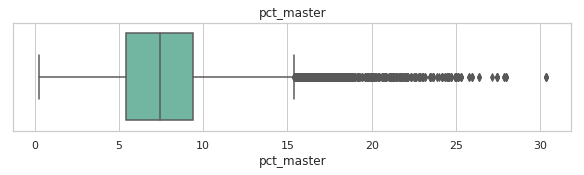

In [54]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_master", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_master")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

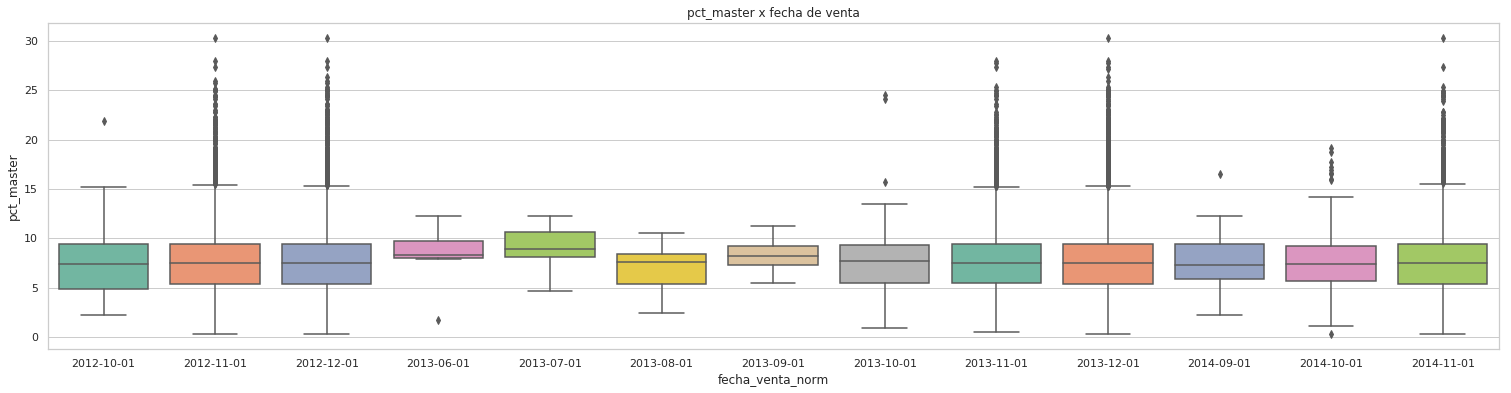

In [55]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_master", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_master x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_bicicleta


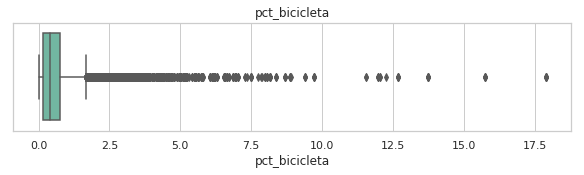

In [56]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_bicicleta", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bicicleta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

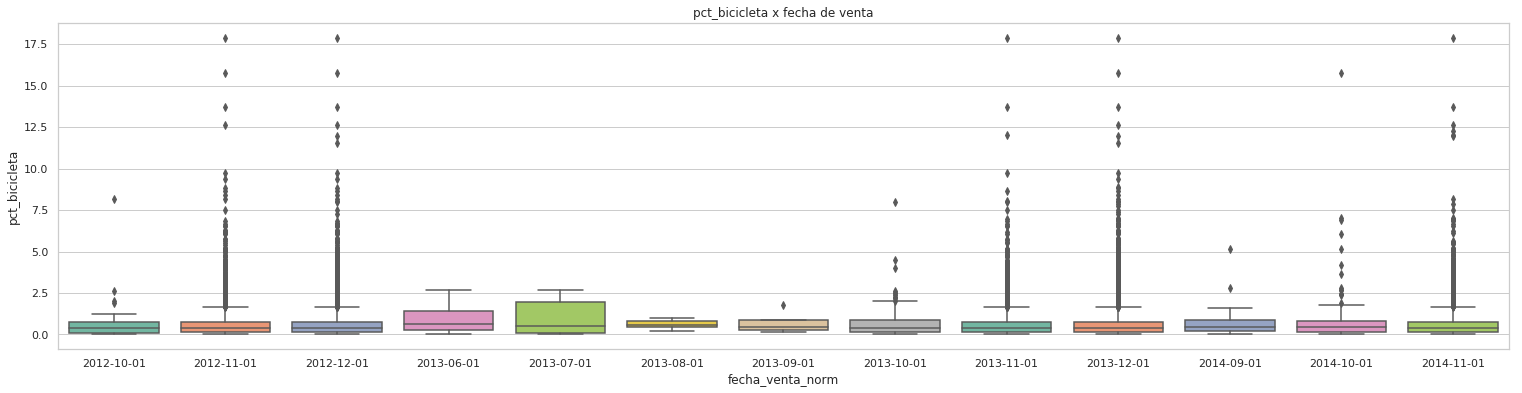

In [57]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_bicicleta", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_bicicleta x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_omnibus


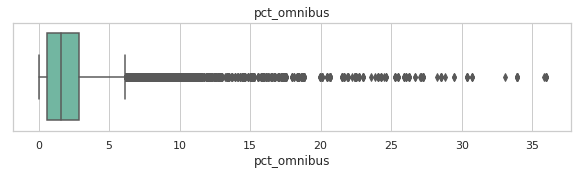

In [58]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_omnibus", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_omnibus")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

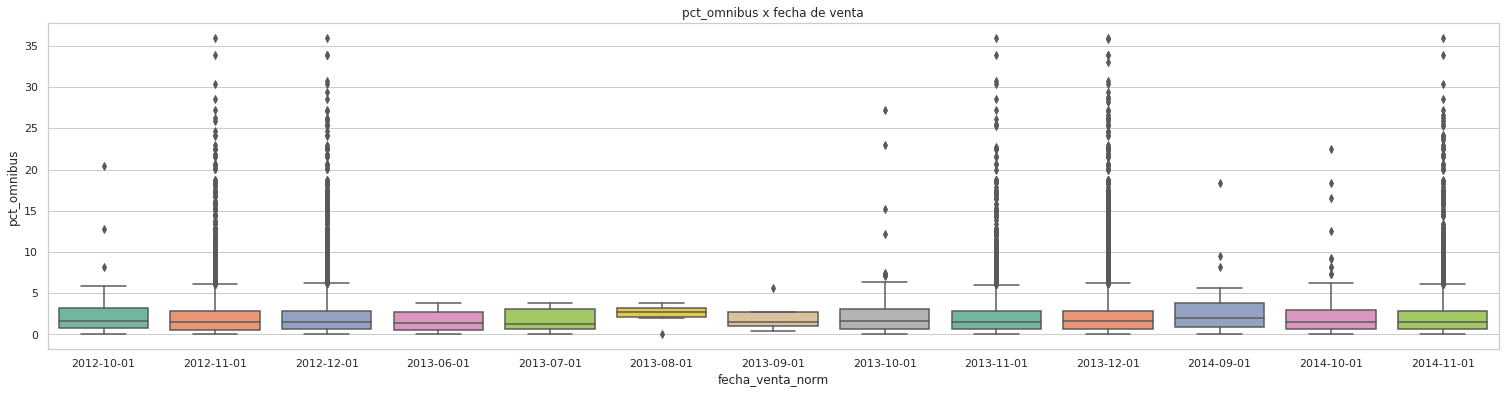

In [59]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_omnibus", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_omnibus x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_subtes

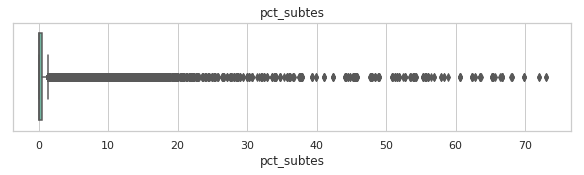

In [60]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_subtes", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_subtes")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

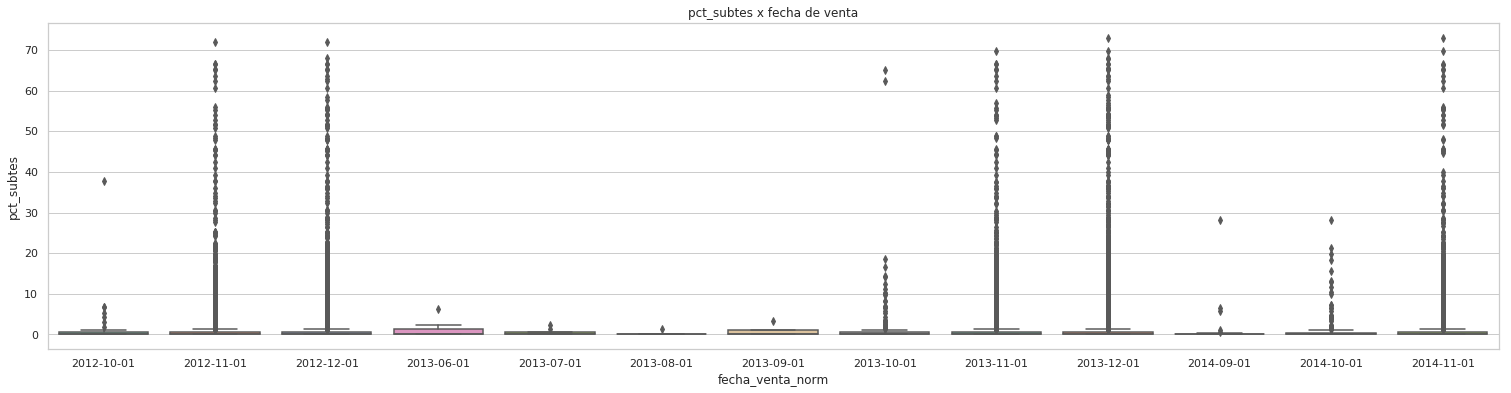

In [61]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_subtes", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_subtes x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_taxi


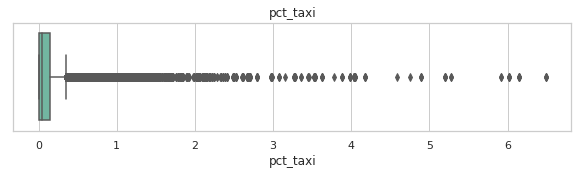

In [62]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_taxi", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_taxi")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

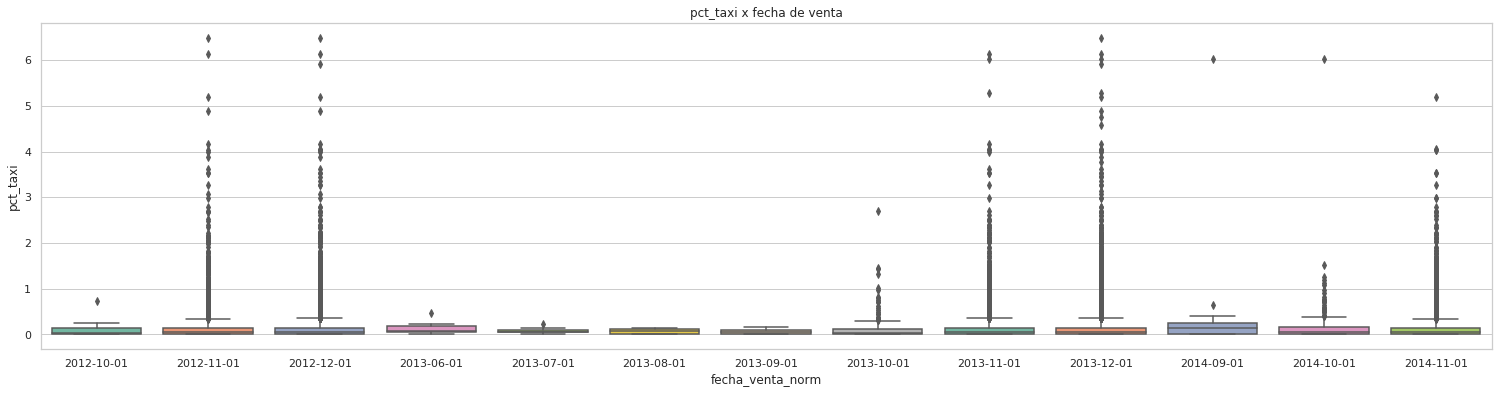

In [63]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_taxi", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_taxi x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### pct_caminata


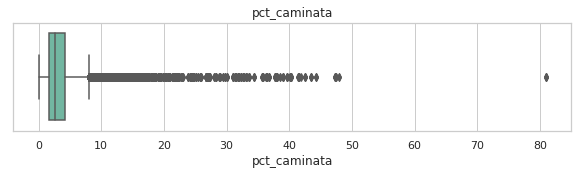

In [64]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="pct_caminata", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_caminata")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

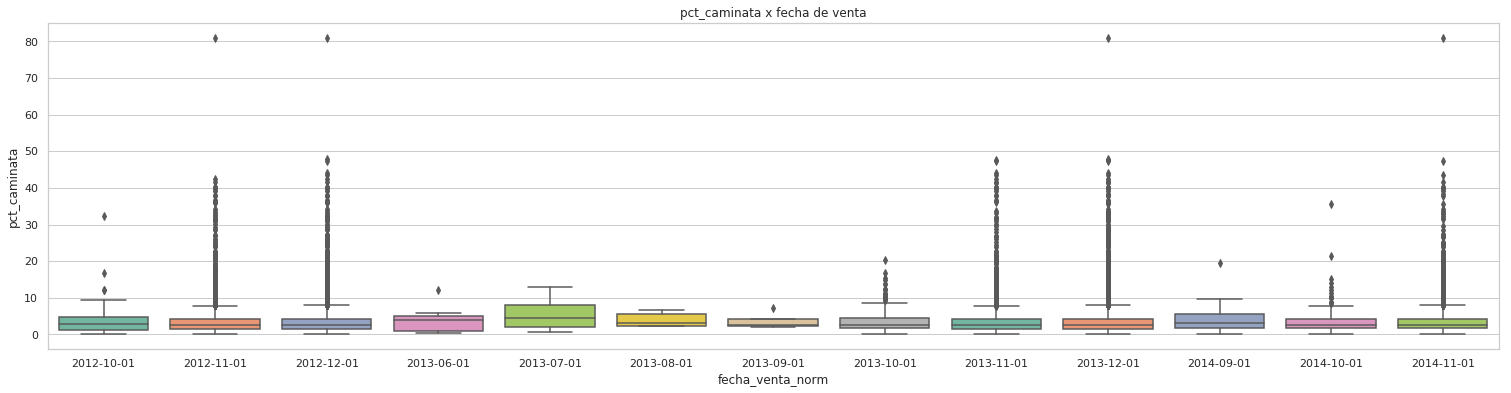

In [65]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="pct_caminata", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("pct_caminata x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### mediana_valor_hogar


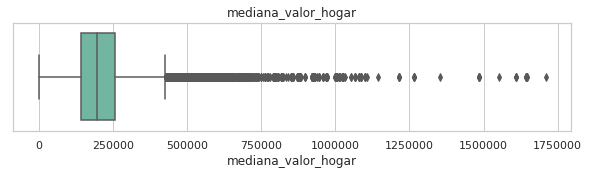

In [66]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="mediana_valor_hogar", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("mediana_valor_hogar")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

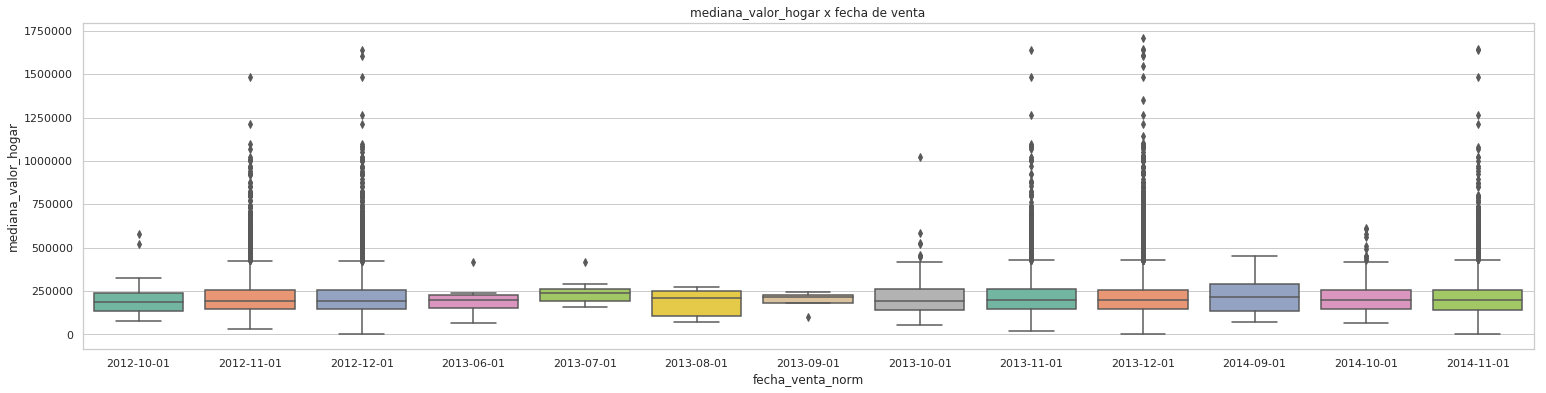

In [67]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 6))
ax = sns.boxplot(x="fecha_venta_norm", y="mediana_valor_hogar", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('fecha_venta_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("mediana_valor_hogar x fecha de venta")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### Edades %
- Se observa que las distribucion de todos los rangos de edades se mantienen entre 7 y 9 %.
- Los de edad longeava son los que poseen valores de distribucion mas bajo
- LOs outliers deben corresponder a zonas donde la distribucion de edades en esos rangos es mayor. La mayoria se observa en los rangos de edad joven.

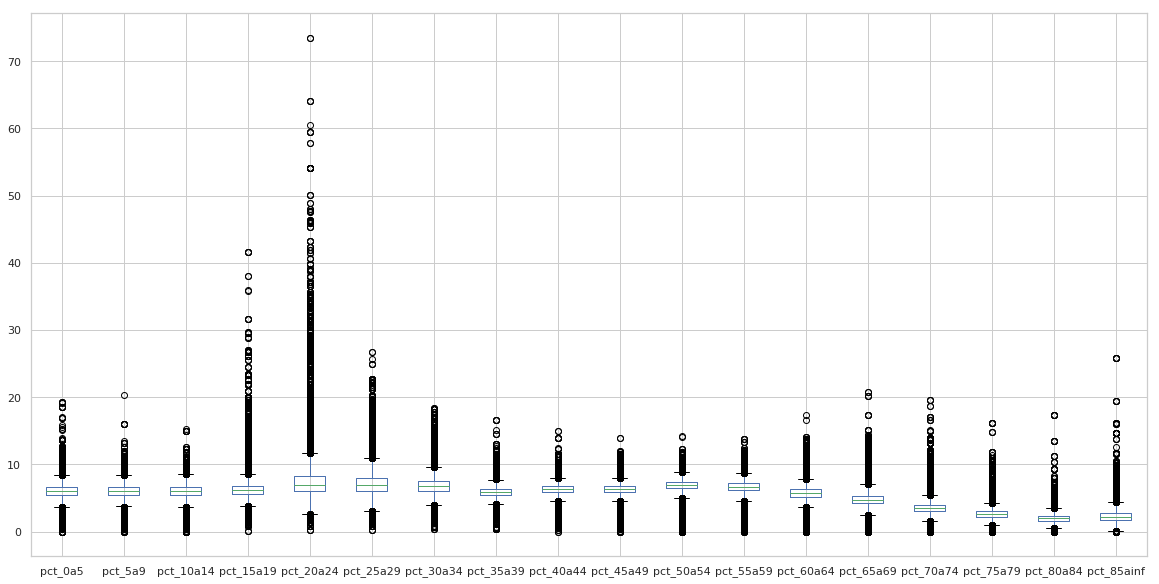

In [68]:
plt.figure(figsize=(20, 10))
rawdata.boxplot(column=['pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf'])
pass

#### id_pos
- La mayoria de los pos de ventas han realizado un numero de cantidad de ventas menor a 20 en el universo de estudio.
- No hay un numero de transacciones de ventas equitativo entre todos los pos de ventas.

In [20]:
pos_aggr = rawdata.groupby('id_pos').size().reset_index()
pos_aggr.columns = ['id_pos','numreg']

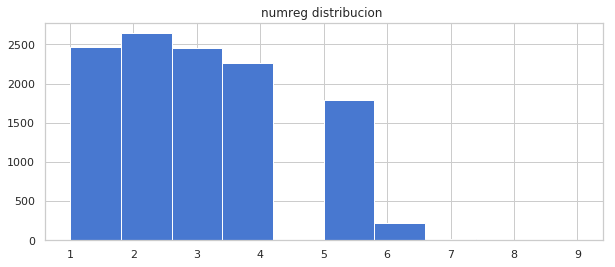

In [22]:
plt.figure(figsize=(10, 4))
simpleHistGraph('numreg',pos_aggr)

In [71]:
pos_aggr = rawdata.groupby('fecha_venta_norm').id_pos.nunique().reset_index()

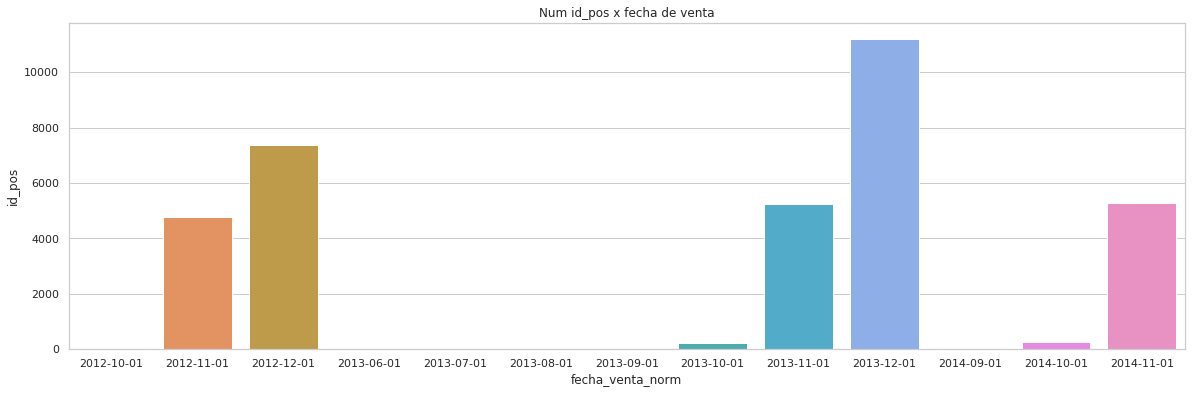

In [72]:
plt.figure(figsize=(20, 6))

ax = sns.barplot(x="fecha_venta_norm", y="id_pos", data=pos_aggr)
ax.set_title("Num id_pos x fecha de venta")
pass


In [73]:
rawdata.groupby('id_pos').size().sort_values(ascending=False).head(20)

id_pos
8858    9
8258    9
8551    9
8875    8
8253    8
7175    7
8863    7
5574    7
8843    7
4885    7
4890    7
3692    7
8252    7
4772    7
5394    7
3531    7
6175    6
3388    6
7949    6
7925    6
dtype: int64

<Figure size 1296x1296 with 0 Axes>

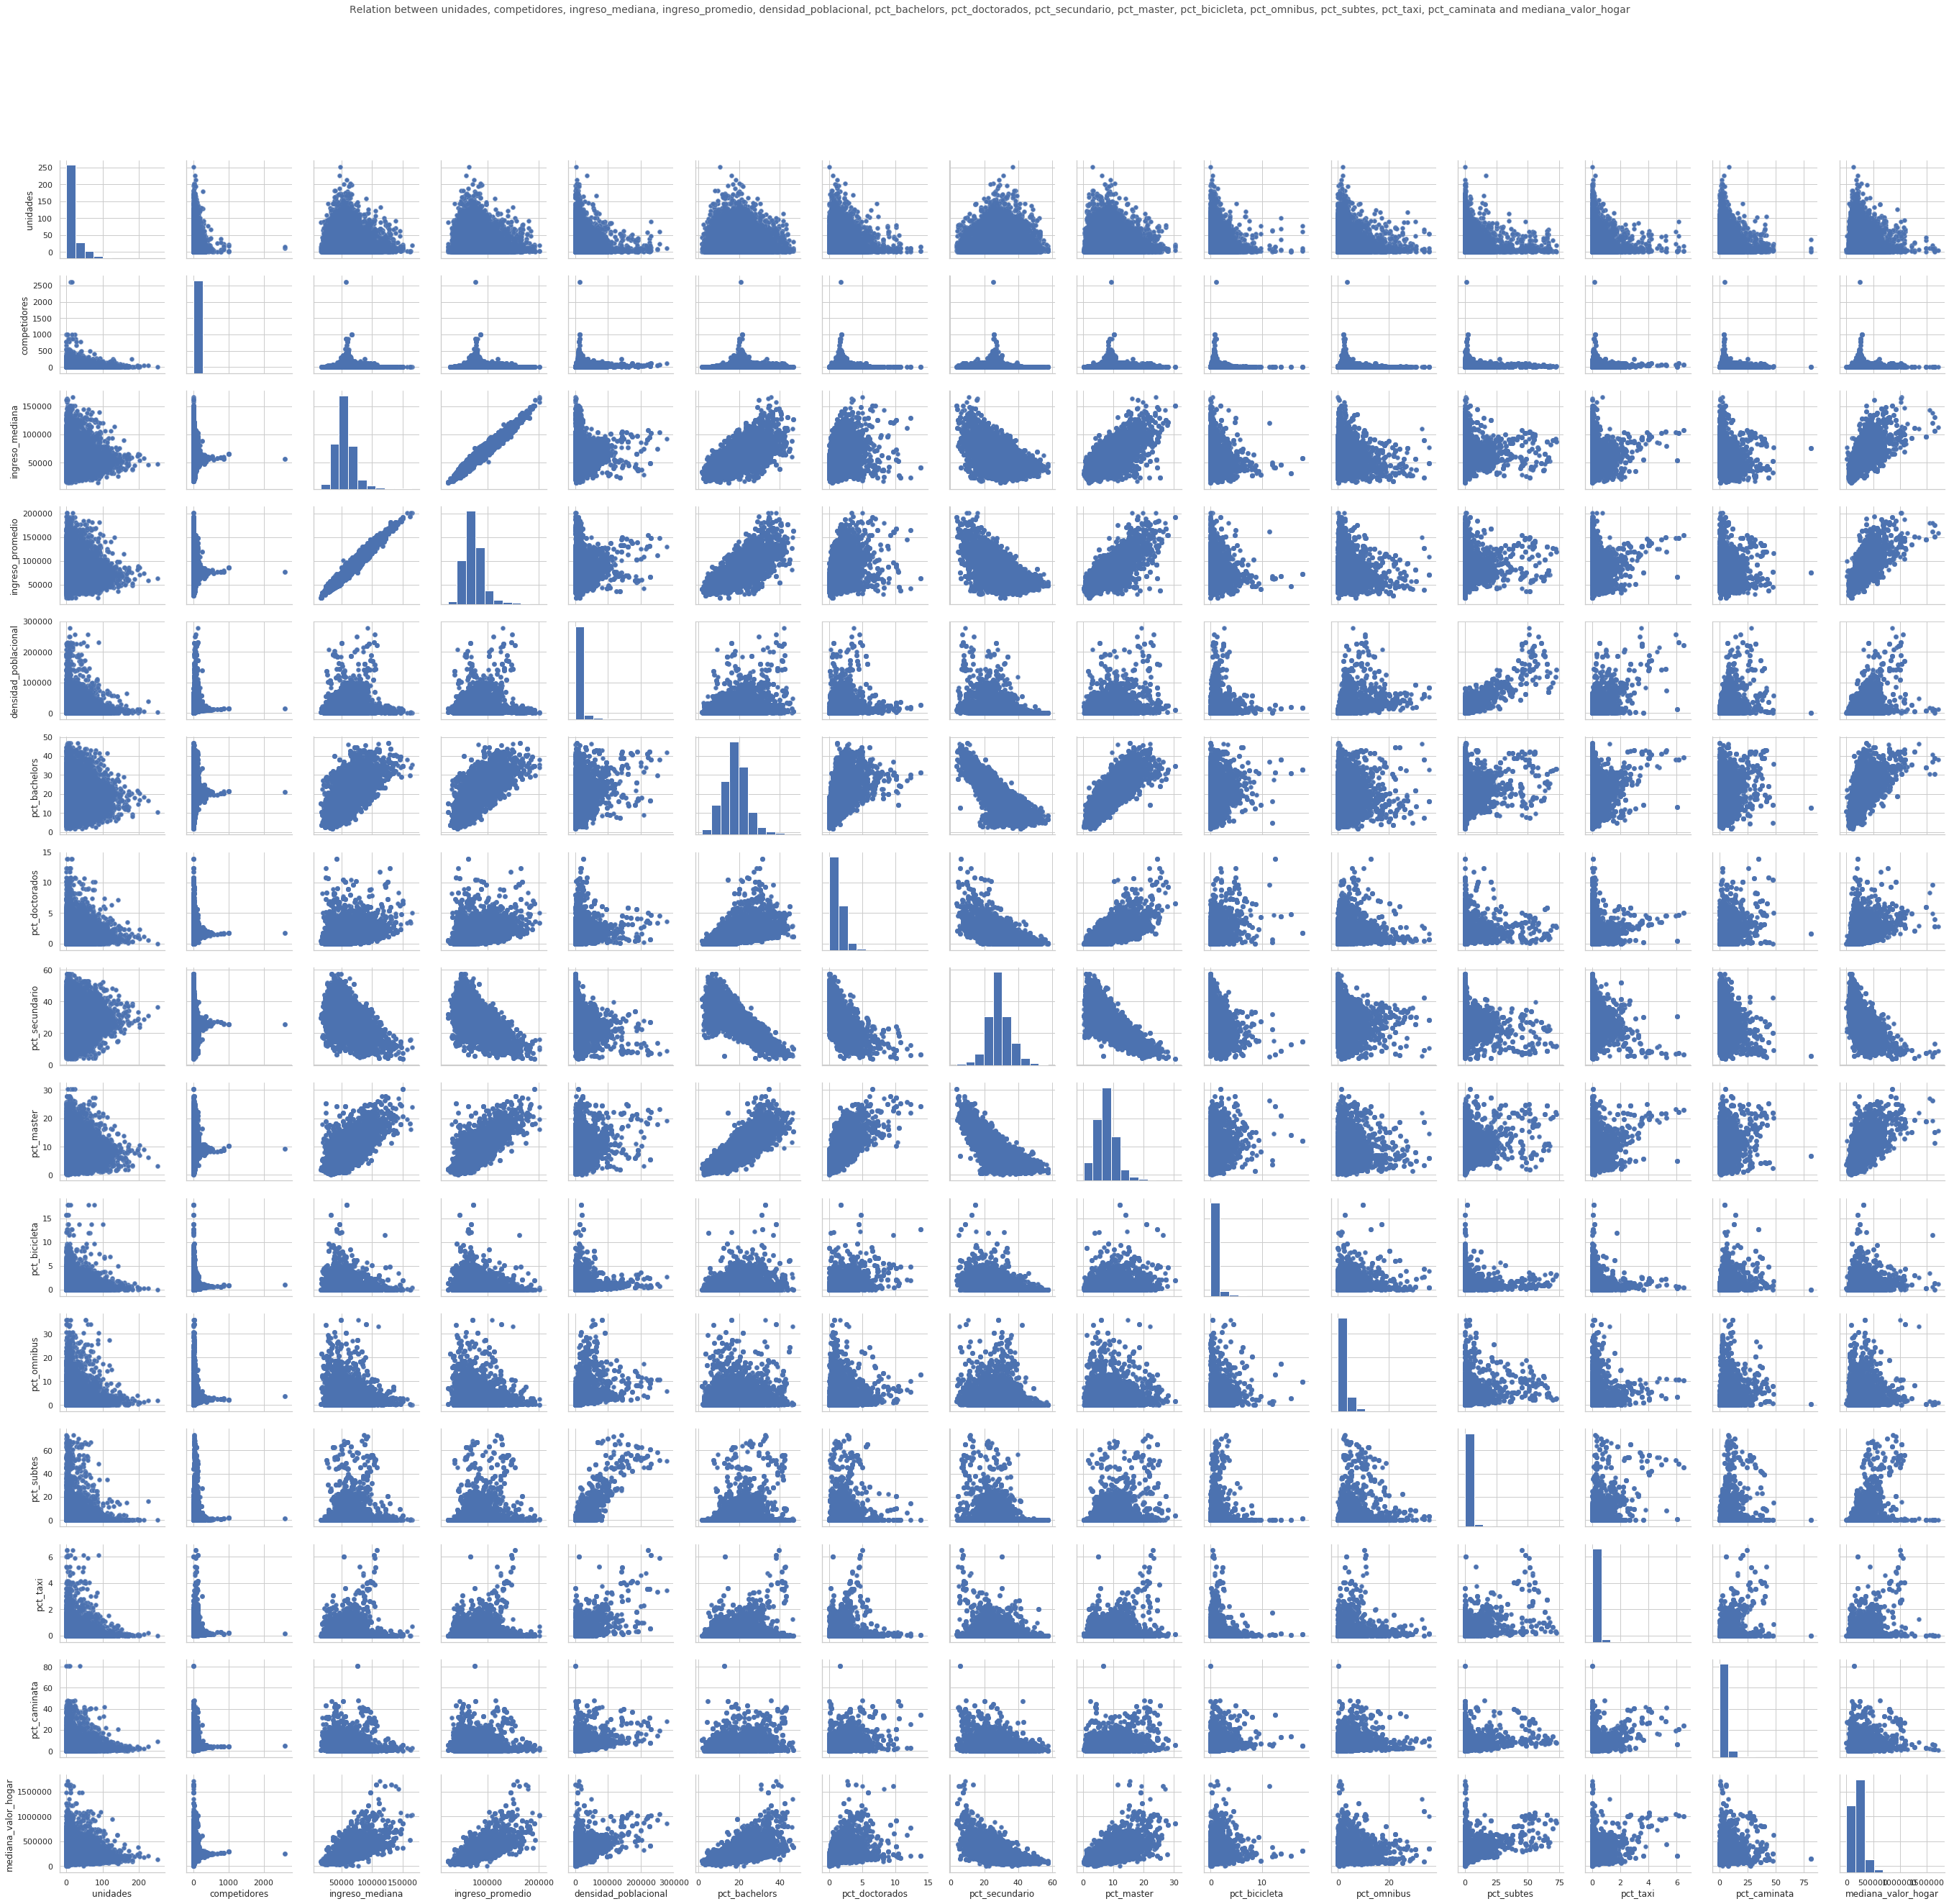

In [74]:
# =================================================
#  Scatterplot Matrix (Scatterplot + distribution)
# =================================================

var = ['unidades', 'competidores',
       'ingreso_mediana', 'ingreso_promedio', 'densidad_poblacional','pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar'] # put all the numeric vars to analyze + target (or categoical value used in hue) 
         # exp: ["numvar1", "numvar2",.. "numvarn", target]
         # Note: drop null values with dropna function.
        
plt.figure(figsize=(18, 18))
g = sns.pairplot(rawdata[var], 
                  palette = colors,
                                           # will also have different scatterplot markers.
                 kind='scatter' # 'scatter' or 'reg' Kind of plot for the non-identity relationships.
                 )


# To change the size of the scatterpoints in graph
g = g.map_offdiag(plt.scatter,  s=35,alpha=0.5)

# remove the top and right line in graph
sns.despine()

# Additional line to adjust some appearance issue
plt.subplots_adjust(top=0.9)

# Set the Title of the graph from here
g.fig.suptitle('Relation between ' + ', '.join([s  for s in var[:len(var)-1]]) + ' and ' + var[len(var)-1],
	fontsize=14,color="black",alpha=0.7)

pass

In [25]:
rawdata['decil'] = pd.qcut(rawdata.unidades, 10, duplicates='drop', labels=False)

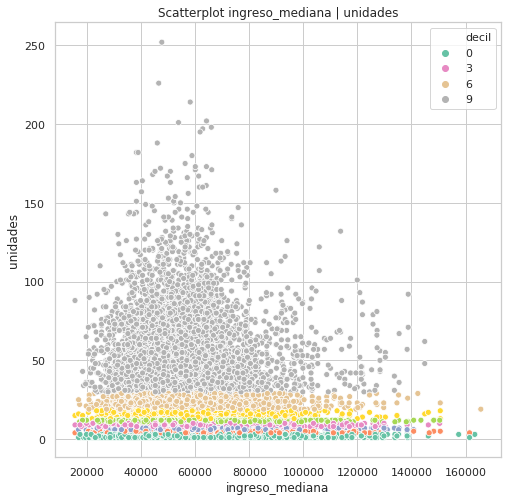

In [33]:
plt.figure(figsize=(8, 8))
x= "ingreso_mediana"
y= "unidades"
ax = sns.scatterplot(x=x, y=y, hue="decil", palette="Set2", data=rawdata)
ax.set_title("Scatterplot " + x + " | " + y)
pass

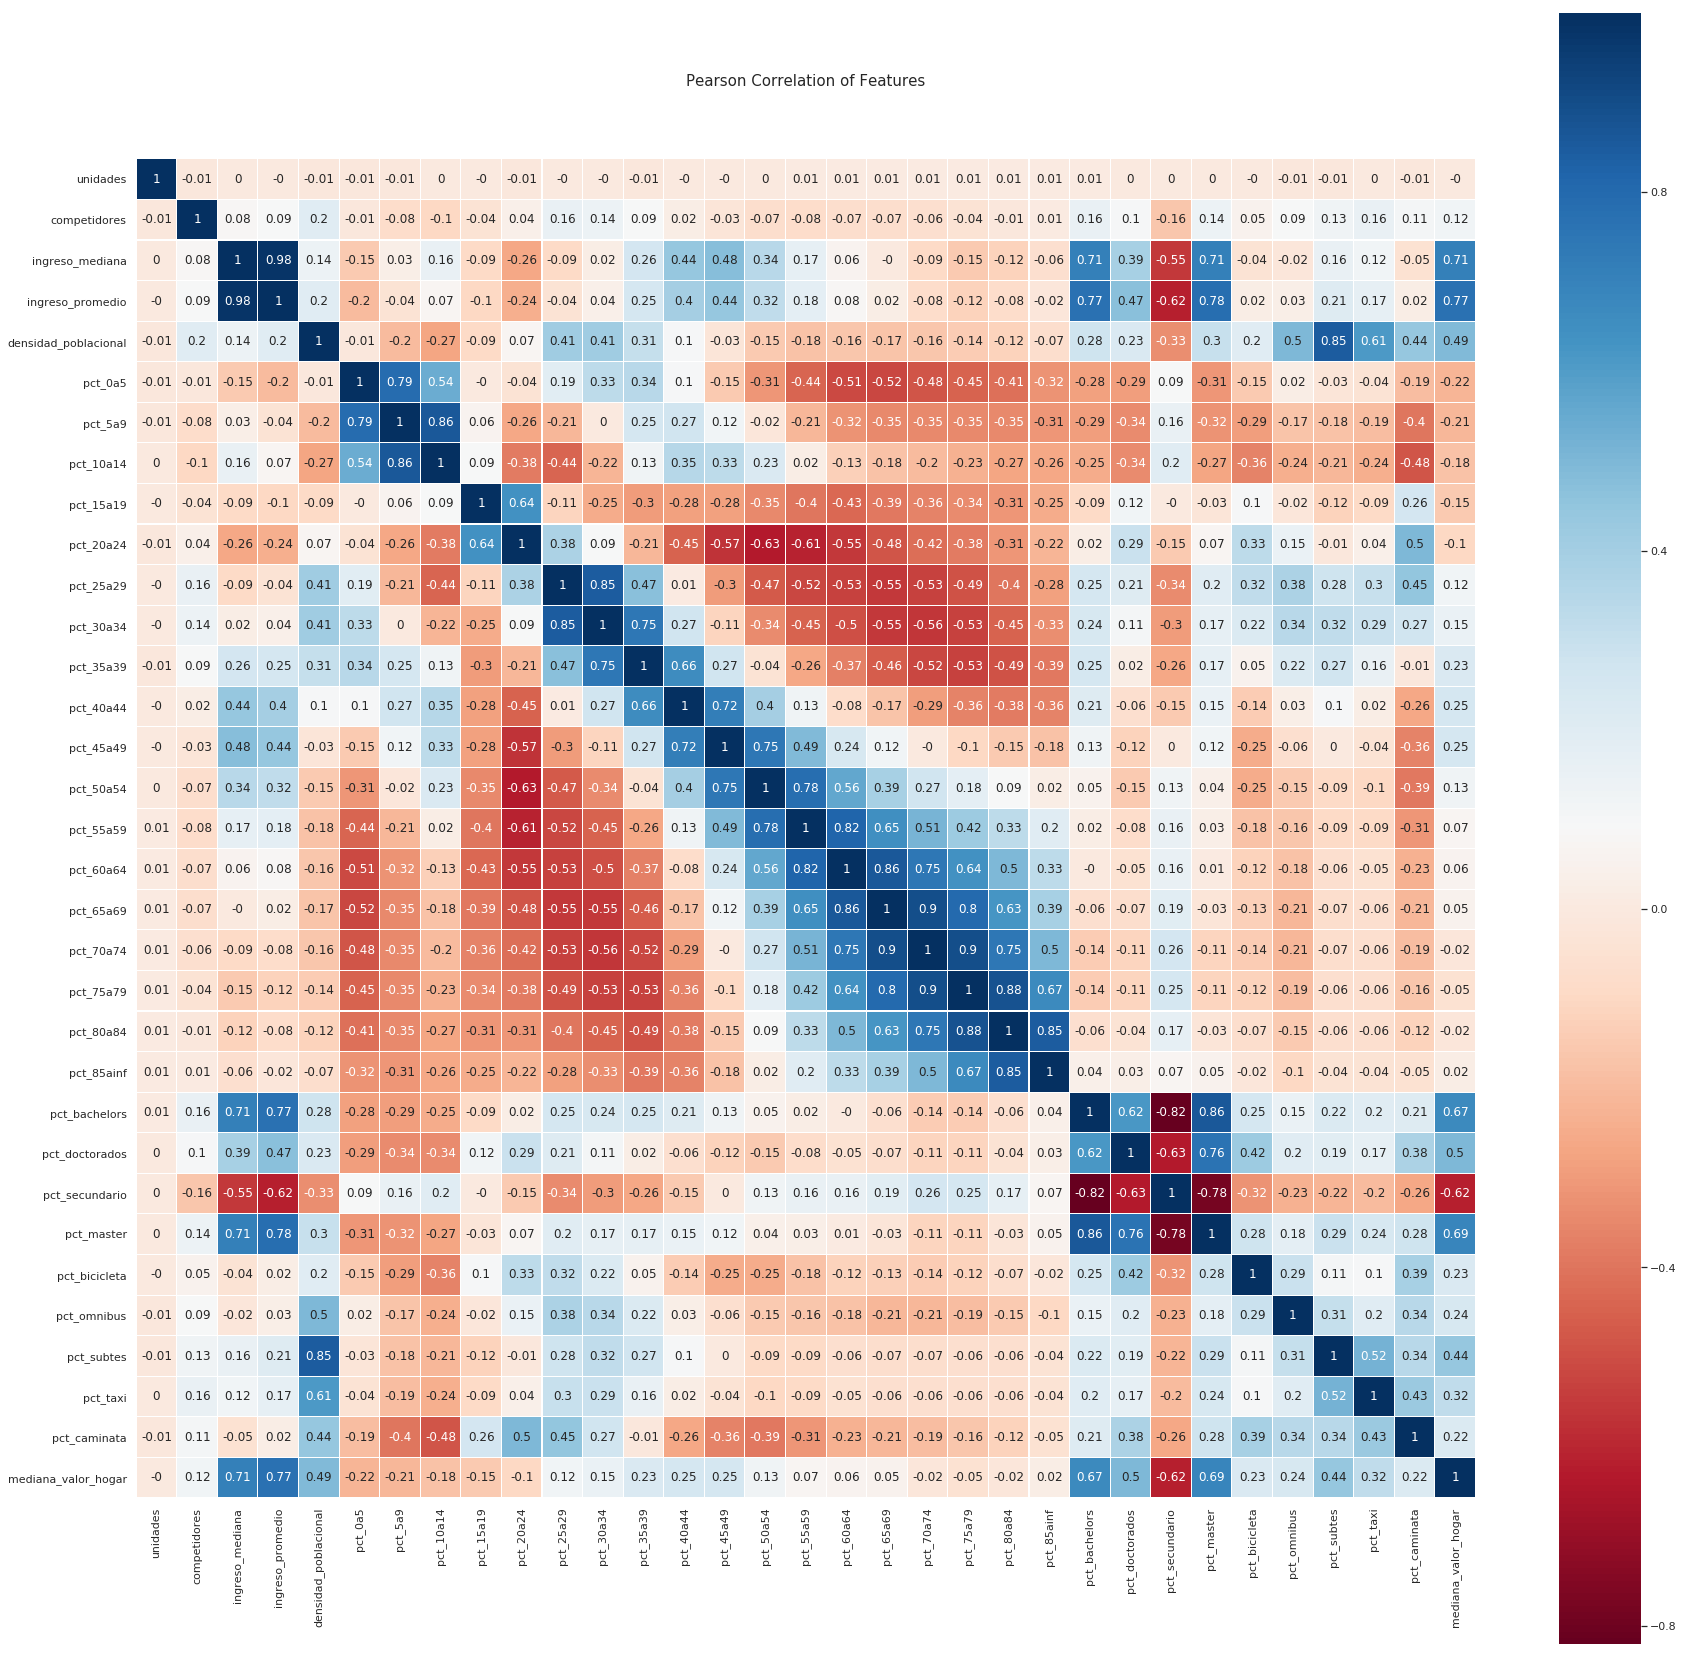

In [76]:
# ====================
#  HeatMap Correlation
# ====================

# select only numerical data. Drop or replace null values
col_names = ['unidades', 'competidores',
       'ingreso_mediana', 'ingreso_promedio', 'densidad_poblacional',
       'pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf', 'pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar']
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(rawdata[col_names].astype(float).corr().round(2), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
pass

### Missing value analysis

In [77]:
# To check if there are any null values in the dataset
rawdata.isnull().values.any() 

True

In [78]:
rawdata.isnull().sum()

id_pos                   0
fecha_venta_norm         0
canal                    0
unidades                 0
competidores            75
ingreso_mediana          3
ingreso_promedio         3
densidad_poblacional     4
pct_0a5                  0
pct_5a9                  4
pct_10a14                5
pct_15a19                0
pct_20a24                4
pct_25a29                4
pct_30a34                4
pct_35a39                4
pct_40a44                4
pct_45a49                4
pct_50a54                4
pct_55a59                4
pct_60a64                4
pct_65a69                4
pct_70a74                4
pct_75a79                4
pct_80a84                4
pct_85ainf               4
pct_bachelors            4
pct_doctorados           4
pct_secundario           4
pct_master               4
pct_bicicleta            4
pct_omnibus              4
pct_subtes               4
pct_taxi                 4
pct_caminata             4
mediana_valor_hogar      0
dtype: int64

### Explore Categorical Data

#### canal
- La mayoria de los id_pos pertenecen a la categoria 'ALMACEN'

In [20]:
rawdata.groupby(['canal']).id_pos.nunique()

canal
ALMACEN          11817
MAXIKIOSCO         108
PARTICULARES         5
SUPERMERCADOS        2
Name: id_pos, dtype: int64

In [23]:
rawdata_tmp = rawdata.groupby(['id_pos']).canal.nunique().reset_index()

In [30]:
rawdata[rawdata.id_pos.isin(rawdata_tmp[rawdata_tmp.canal > 1]['id_pos'].values)][['id_pos','canal','fecha_venta_norm','unidades']]

,id_pos,canal,fecha_venta_norm,unidades
93,3176,ALMACEN,2012-11-01,1
94,3176,ALMACEN,2012-12-01,58
95,3176,ALMACEN,2013-11-01,5
96,3176,ALMACEN,2013-12-01,29
97,3176,SUPERMERCADOS,2013-12-01,12
98,3176,SUPERMERCADOS,2014-11-01,1
99,3177,ALMACEN,2013-11-01,3
100,3177,ALMACEN,2013-12-01,21
101,3177,SUPERMERCADOS,2013-12-01,14
102,3177,SUPERMERCADOS,2014-11-01,2


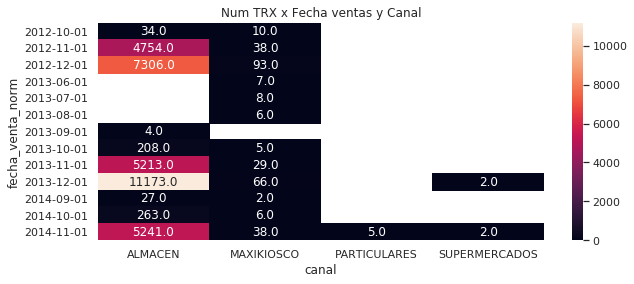

In [40]:
plt.figure(figsize=(10,4))
df = rawdata.pivot_table(index='fecha_venta_norm', columns='canal', 
                         values='unidades', 
                         aggfunc=np.count_nonzero) # chouse a math function from numpy
ax = sns.heatmap(df, annot=True, fmt=".1f")
ax.set_title("Num TRX x Fecha ventas y Canal")
plt.show()

In [47]:
rawdata['year'] = pd.to_datetime(rawdata.fecha_venta_norm).dt.year
rawdata['month'] = pd.to_datetime(rawdata.fecha_venta_norm).dt.month


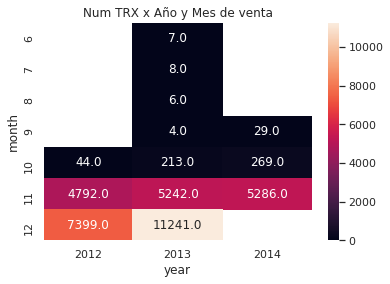

In [48]:
plt.figure(figsize=(6,4))
df = rawdata.pivot_table(index='month', columns='year', 
                         values='unidades', 
                         aggfunc=np.count_nonzero) # chouse a math function from numpy
ax = sns.heatmap(df, annot=True, fmt=".1f")
ax.set_title("Num TRX x Año y Mes de venta")
plt.show()

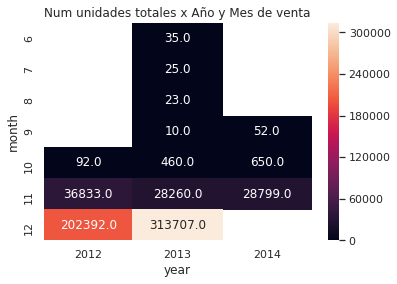

In [49]:
plt.figure(figsize=(6,4))
df = rawdata.pivot_table(index='month', columns='year', 
                         values='unidades', 
                         aggfunc=np.sum) # chouse a math function from numpy
ax = sns.heatmap(df, annot=True, fmt=".1f")
ax.set_title("Num unidades totales x Año y Mes de venta")
plt.show()

## Envios

#### Load Data

In [31]:
envios = pd.read_csv('../data/raw/envios.txt', sep='|')

### Describe Data

In [21]:
envios.shape

(42434, 4)

In [22]:
envios.head()

,fecha,id_pos,unidades_despachadas,cantidad_envios
0,2012-08-17,5235,36,1
1,2012-08-24,4611,48,1
2,2012-08-24,4645,48,1
3,2012-08-24,4649,72,1
4,2012-08-24,4677,72,1


In [23]:
envios.sample(n=5)

,fecha,id_pos,unidades_despachadas,cantidad_envios
9885,2013-08-16,8353,84,1
674,2012-10-19,13171,12,1
17700,2013-09-20,8142,24,1
37635,2014-10-18,3712,12,1
26464,2014-09-13,11106,24,1


In [24]:
envios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42434 entries, 0 to 42433
Data columns (total 4 columns):
fecha                   42434 non-null object
id_pos                  42434 non-null int64
unidades_despachadas    42434 non-null int64
cantidad_envios         42434 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [25]:
envios.describe(include=['O']) # category data

,fecha
count,42434
unique,41
top,2012-10-19
freq,9452


In [26]:
envios.describe() # numerical data

,id_pos,unidades_despachadas,cantidad_envios
count,42434.000000,42434.000000,42434.000000
mean,9453.247632,35.532827,1.000165
std,5678.198406,32.258875,0.012843
min,3142.000000,12.000000,1.000000
25%,5487.000000,12.000000,1.000000
50%,7720.500000,24.000000,1.000000
75%,12792.000000,48.000000,1.000000
max,63432.000000,528.000000,2.000000


In [27]:
print(envios.nunique())

fecha                      41
id_pos                  13449
unidades_despachadas       33
cantidad_envios             2
dtype: int64


In [37]:
envios['fecha'] = pd.to_datetime(envios['fecha'])

NameError: name 'envios' is not defined

In [33]:
envios['fecha_norm'] = envios['fecha'].apply(lambda x : date(x.year,x.month,1))

#### unidades_despachadas

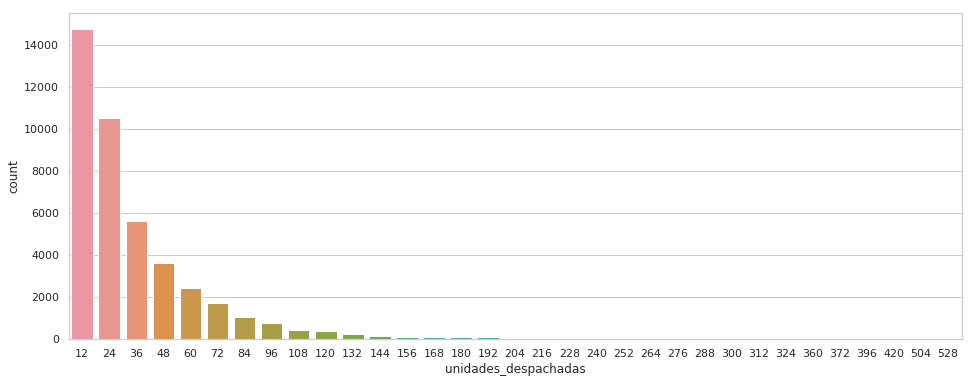

In [34]:
# =========================
#  Target Barplot (count)
# =========================
plt.figure(figsize=(16, 6))
sns.countplot(x='unidades_despachadas', data=envios)
pass

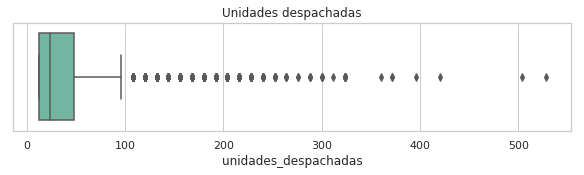

In [35]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="unidades_despachadas", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades despachadas")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

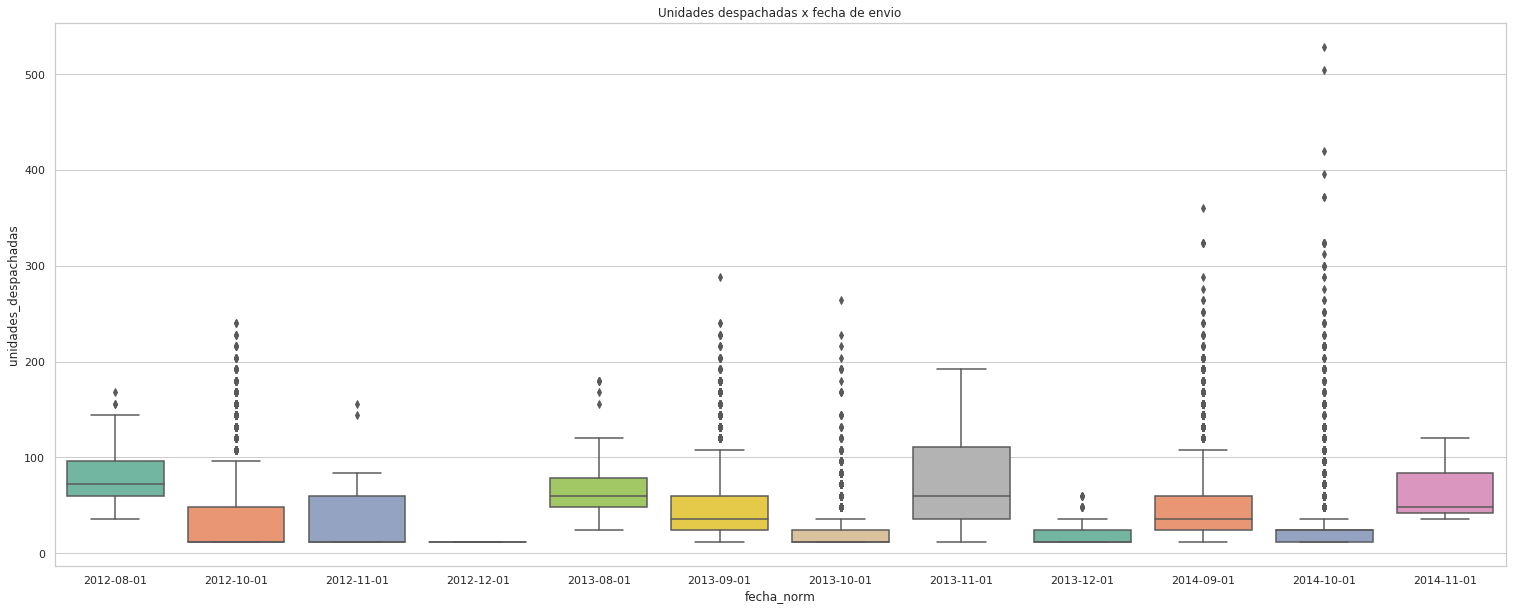

In [37]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_norm", y="unidades_despachadas", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios.sort_values('fecha_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("Unidades despachadas x fecha de envio")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- La mayoria de las trx ocurren en los meses anteriores a los festivos (9 y 10) de cada año. No se observa casi nada de activadad en los meses restantes


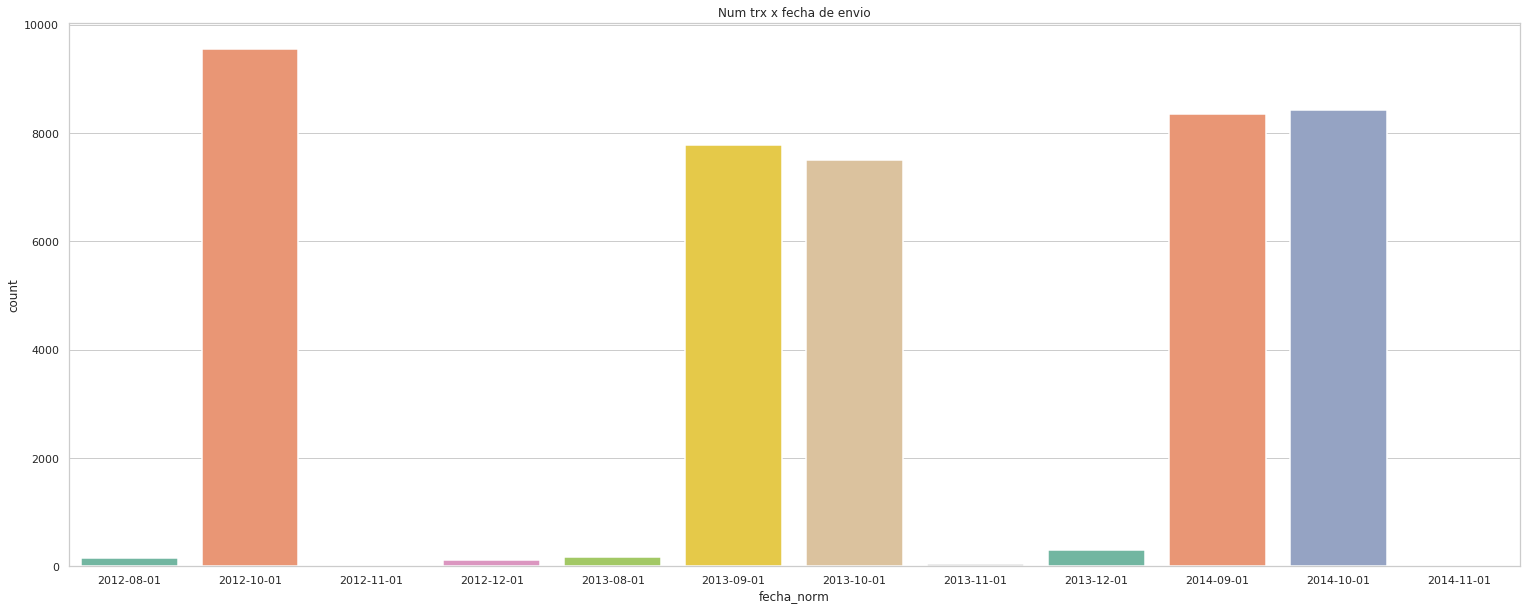

In [38]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.countplot(x="fecha_norm",           linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios.sort_values('fecha_norm'))
ax.set_title("Num trx x fecha de envio")
pass

#### cantidad_envios

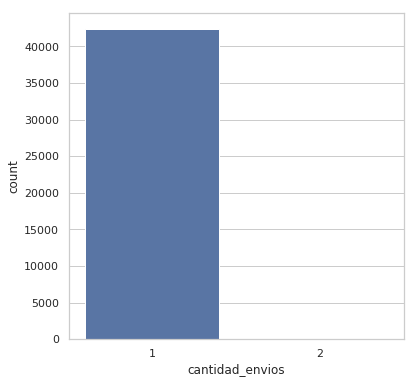

In [40]:
# =========================
#  Target Barplot (count)
# =========================
plt.figure(figsize=(6, 6))
sns.countplot(x='cantidad_envios', data=envios)
pass

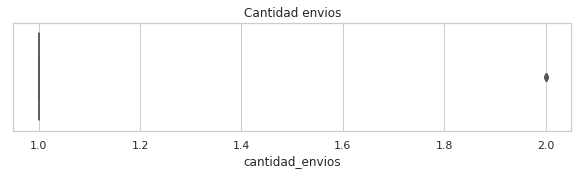

In [41]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 2))
ax = sns.boxplot(x="cantidad_envios", 
                #hue = "catvar or target",
                 orient="h",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios) # DataFrame, array, or list of arrays, optional
ax.set_title("Cantidad envios")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

- 

- La mayoria de las trx ocurren en los meses anteriores a los festivos (9 y 10) de cada año. No se observa casi nada de activadad en los meses restantes


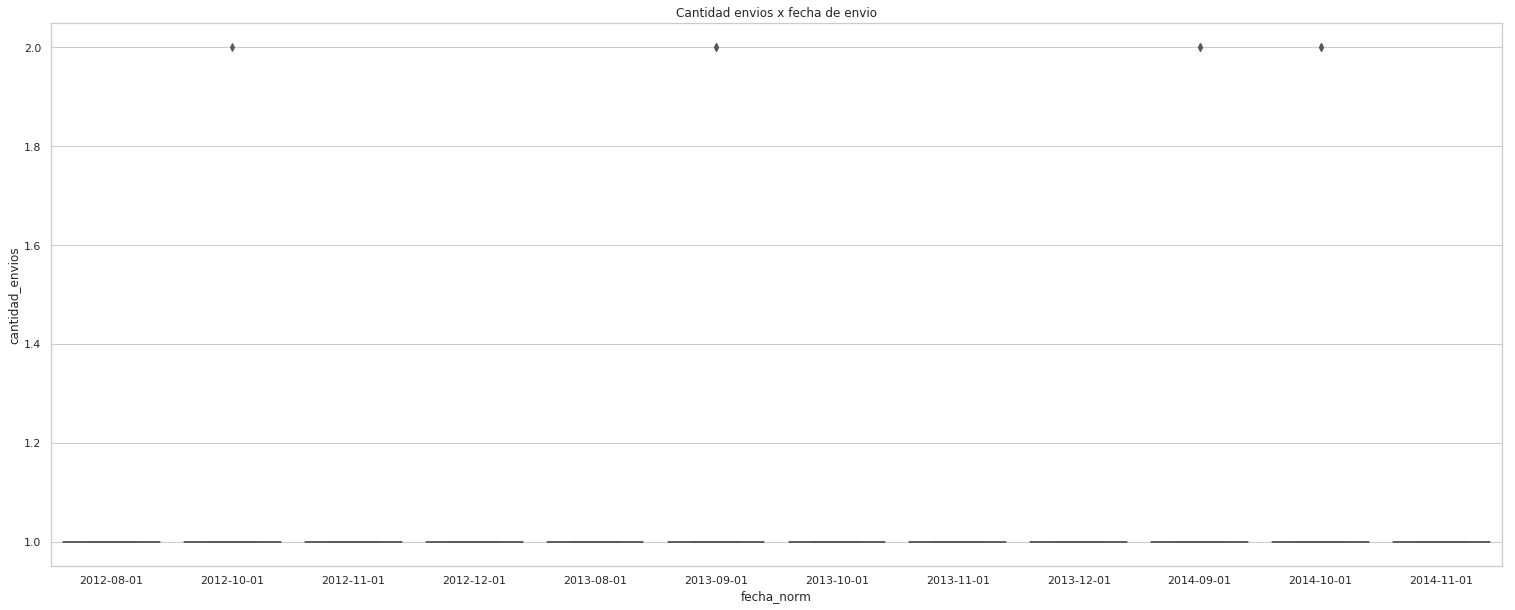

In [42]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="fecha_norm", y="cantidad_envios", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=envios.sort_values('fecha_norm')) # DataFrame, array, or list of arrays, optional
ax.set_title("Cantidad envios x fecha de envio")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

#### id_pos
- La mayoria de los pos de ventas han realizado un numero de cantidad de ventas menor a 20 en el universo de estudio.
- No hay un numero de transacciones de ventas equitativo entre todos los pos de ventas.

In [43]:
pos_aggr = envios.groupby('id_pos').size().reset_index()
pos_aggr.columns = ['id_pos','numreg']

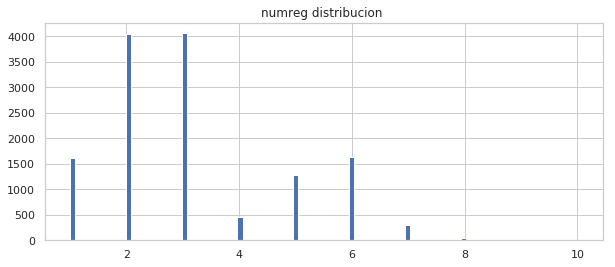

In [44]:
plt.figure(figsize=(10, 4))
simpleHistGraph('numreg',pos_aggr, bins=100)

In [45]:
envios.groupby('id_pos').size().sort_values(ascending=False).head(20)

id_pos
3566     10
3718      9
5997      9
3789      9
3921      9
4016      9
7243      8
3905      8
7919      8
3274      8
3200      8
3903      8
28141     8
4547      8
3707      8
27803     8
6667      8
3473      8
3481      8
5547      8
dtype: int64

#### Missing value analysis
- No posee valores nulos

In [46]:
# To check if there are any null values in the dataset
envios.isnull().values.any() 

False

In [47]:
envios.isnull().sum()

fecha                   0
id_pos                  0
unidades_despachadas    0
cantidad_envios         0
fecha_norm              0
dtype: int64

### Envios Pivot

In [20]:
envios_pivot = pd.read_csv('../data/processed/envios_pivoted.csv', sep=';')

In [22]:
envios_pivot.shape

(13449, 61)

In [23]:
envios_pivot.head()

,id_pos,unidades_despachadas_sum201210,unidades_despachadas_sum20139,unidades_despachadas_sum201310,unidades_despachadas_sum20149,unidades_despachadas_sum201410,unidades_despachadas_max201210,unidades_despachadas_max20139,unidades_despachadas_max201310,unidades_despachadas_max20149,unidades_despachadas_max201410,unidades_despachadas_min201210,unidades_despachadas_min20139,unidades_despachadas_min201310,unidades_despachadas_min20149,unidades_despachadas_min201410,unidades_despachadas_avg201210,unidades_despachadas_avg20139,unidades_despachadas_avg201310,unidades_despachadas_avg20149,unidades_despachadas_avg201410,num_unidades_despachadas201210,num_unidades_despachadas20139,num_unidades_despachadas201310,num_unidades_despachadas20149,num_unidades_despachadas201410,cantidad_envios_sum201210,cantidad_envios_sum20139,cantidad_envios_sum201310,cantidad_envios_sum20149,cantidad_envios_sum201410,cantidad_envios_max201210,cantidad_envios_max20139,cantidad_envios_max201310,cantidad_envios_max20149,cantidad_envios_max201410,cantidad_envios_min201210,cantidad_envios_min20139,cantidad_envios_min201310,cantidad_envios_min20149,cantidad_envios_min201410,cantidad_envios_avg201210,cantidad_envios_avg20139,cantidad_envios_avg201310,cantidad_envios_avg20149,cantidad_envios_avg201410,num_cantidad_envios201210,num_cantidad_envios20139,num_cantidad_envios201310,num_cantidad_envios20149,num_cantidad_envios201410,fecha_envio_max201210,fecha_envio_max20139,fecha_envio_max201310,fecha_envio_max20149,fecha_envio_max201410,fecha_envio_min201210,fecha_envio_min20139,fecha_envio_min201310,fecha_envio_min20149,fecha_envio_min201410
0,3142,12.0,NaN,12.0,NaN,12.0,12.0,NaN,12.0,NaN,12.0,12.0,NaN,12.0,NaN,12.0,12.0,NaN,12.0,NaN,12.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,2012-10-19,NaN,2013-10-25,NaN,2014-10-18,2012-10-19,NaN,2013-10-25,NaN,2014-10-18
1,3143,NaN,36.0,NaN,24.0,NaN,NaN,36.0,NaN,24.0,NaN,NaN,36.0,NaN,24.0,NaN,NaN,36.0,NaN,24.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,2013-09-13,NaN,2014-09-13,NaN,NaN,2013-09-13,NaN,2014-09-13,NaN
2,3144,48.0,108.0,NaN,60.0,36.0,48.0,72.0,NaN,60.0,24.0,48.0,36.0,NaN,60.0,12.0,48.0,54.0,NaN,60.0,18.0,1.0,2.0,NaN,1.0,2.0,1.0,2.0,NaN,1.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN,1.0,2.0,2012-10-19,2013-09-20,NaN,2014-09-13,2014-10-18,2012-10-19,2013-09-13,NaN,2014-09-13,2014-10-18
3,3146,12.0,NaN,12.0,NaN,12.0,12.0,NaN,12.0,NaN,12.0,12.0,NaN,12.0,NaN,12.0,12.0,NaN,12.0,NaN,12.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,2012-10-19,NaN,2013-10-25,NaN,2014-10-18,2012-10-19,NaN,2013-10-25,NaN,2014-10-18
4,3147,48.0,60.0,NaN,48.0,NaN,48.0,60.0,NaN,48.0,NaN,48.0,60.0,NaN,48.0,NaN,48.0,60.0,NaN,48.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,2012-10-19,2013-09-20,NaN,2014-09-13,NaN,2012-10-19,2013-09-20,NaN,2014-09-13,NaN


In [24]:
rawdata = pd.merge(rawdata, envios_pivot, how='inner', on='id_pos')

In [25]:
rawdata.shape

(34538, 96)

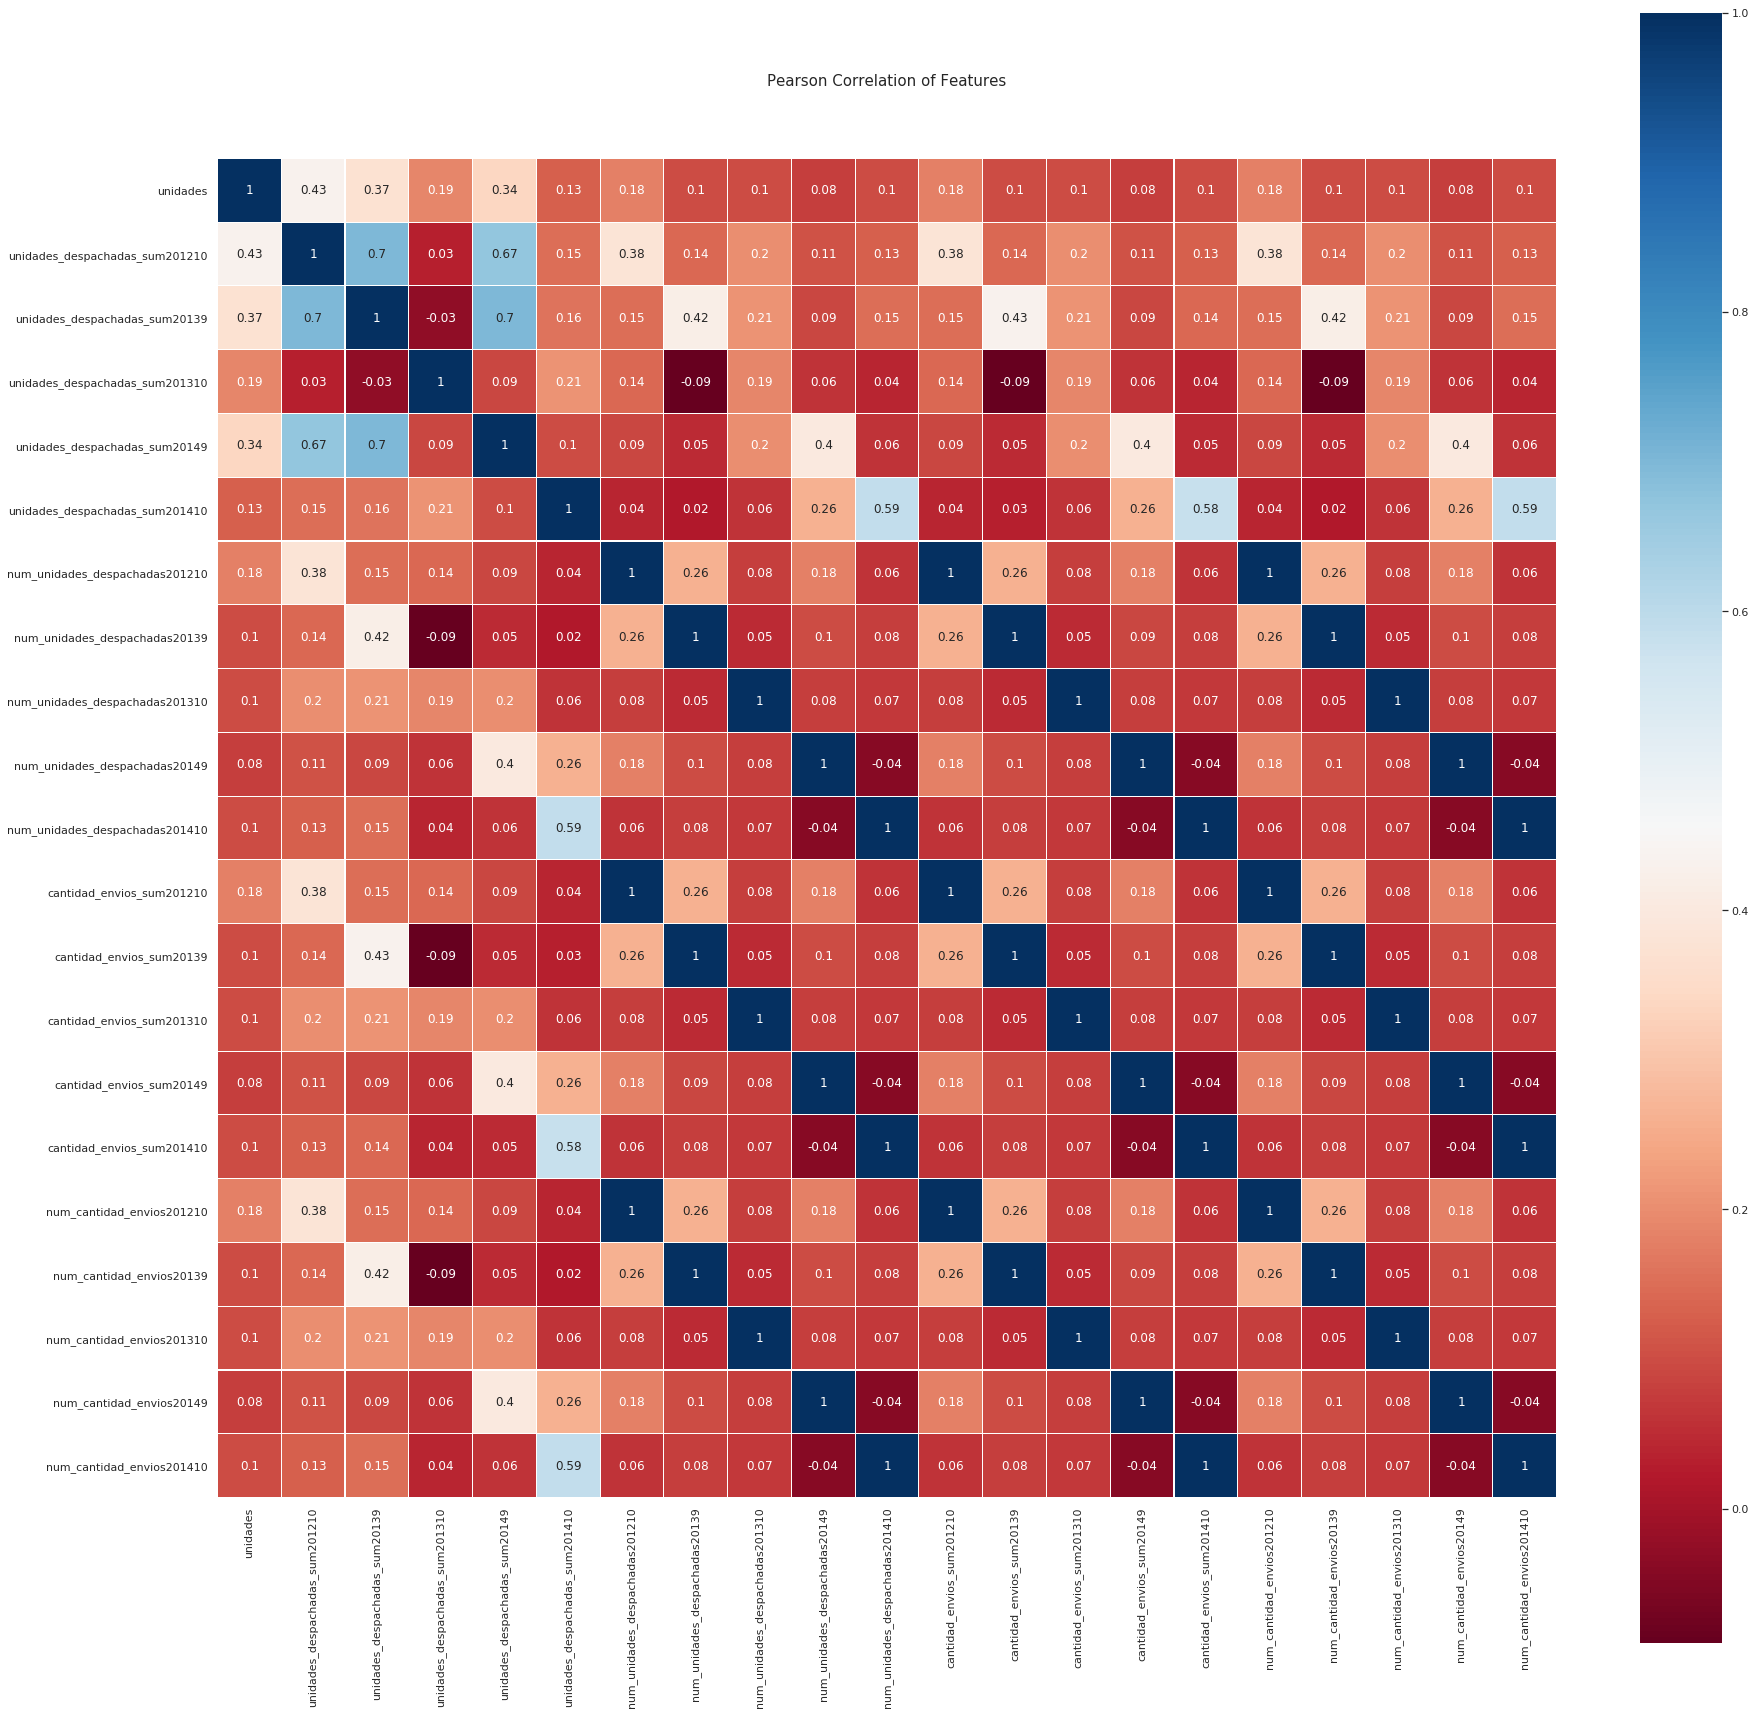

In [29]:
# ====================
#  HeatMap Correlation
# ====================

# select only numerical data. Drop or replace null values
col_names = ['unidades', 
        'unidades_despachadas_sum201210', 'unidades_despachadas_sum20139',
         'unidades_despachadas_sum201310', 'unidades_despachadas_sum20149',
         'unidades_despachadas_sum201410', 
         'num_unidades_despachadas201210', 'num_unidades_despachadas20139',
         'num_unidades_despachadas201310', 'num_unidades_despachadas20149',
         'num_unidades_despachadas201410', 'cantidad_envios_sum201210',
         'cantidad_envios_sum20139', 'cantidad_envios_sum201310',
         'cantidad_envios_sum20149', 'cantidad_envios_sum201410',
         'num_cantidad_envios201210','num_cantidad_envios20139', 
         'num_cantidad_envios201310','num_cantidad_envios20149', 'num_cantidad_envios201410'    
            ]
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(rawdata[col_names].astype(float).corr().round(2), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
pass

In [26]:
envios_pivot.columns.to_list()

['id_pos',
 'unidades_despachadas_sum201210',
 'unidades_despachadas_sum20139',
 'unidades_despachadas_sum201310',
 'unidades_despachadas_sum20149',
 'unidades_despachadas_sum201410',
 'unidades_despachadas_max201210',
 'unidades_despachadas_max20139',
 'unidades_despachadas_max201310',
 'unidades_despachadas_max20149',
 'unidades_despachadas_max201410',
 'unidades_despachadas_min201210',
 'unidades_despachadas_min20139',
 'unidades_despachadas_min201310',
 'unidades_despachadas_min20149',
 'unidades_despachadas_min201410',
 'unidades_despachadas_avg201210',
 'unidades_despachadas_avg20139',
 'unidades_despachadas_avg201310',
 'unidades_despachadas_avg20149',
 'unidades_despachadas_avg201410',
 'num_unidades_despachadas201210',
 'num_unidades_despachadas20139',
 'num_unidades_despachadas201310',
 'num_unidades_despachadas20149',
 'num_unidades_despachadas201410',
 'cantidad_envios_sum201210',
 'cantidad_envios_sum20139',
 'cantidad_envios_sum201310',
 'cantidad_envios_sum20149',
 'cant